### Data Analysis: 

In [1]:
import pandas as pd 
from IPython.display import display
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.express as px
import plotly.io as pio

import matplotlib.ticker as mtick 
import seaborn as sns
import numpy as np

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate, cross_val_predict, cross_val_score,\
    StratifiedKFold, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score, f1_score, confusion_matrix, precision_recall_curve, precision_score, recall_score, auc
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier



from sklearn.utils import shuffle


import warnings

warnings.filterwarnings('ignore')

In [2]:
try:
    contract= pd.read_csv('contract.csv')
    personal = pd.read_csv('personal.csv')
    internet = pd.read_csv('internet.csv')
    phone = pd.read_csv('phone.csv')
    
except:
    contract = pd.read_csv('/datasets/final_provider/contract.csv')
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
    phone = pd.read_csv('/datasets/final_provider/phone.csv') 

- Let's merge data

In [3]:
data = personal.merge(contract, on = 'customerID', how = 'right').merge(internet, on = 'customerID', how = 'right').merge(phone, on = 'customerID', how = 'left')


In [4]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Female,0,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,No


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5517 entries, 0 to 5516
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5517 non-null   object 
 1   gender            5517 non-null   object 
 2   SeniorCitizen     5517 non-null   int64  
 3   Partner           5517 non-null   object 
 4   Dependents        5517 non-null   object 
 5   BeginDate         5517 non-null   object 
 6   EndDate           5517 non-null   object 
 7   Type              5517 non-null   object 
 8   PaperlessBilling  5517 non-null   object 
 9   PaymentMethod     5517 non-null   object 
 10  MonthlyCharges    5517 non-null   float64
 11  TotalCharges      5517 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,5517.0,0.197571,0.398203,0.00,0.00,0.00,0.00,1.00
MonthlyCharges,5517.0,76.844254,21.924661,23.45,59.95,79.45,94.45,118.75


Convert <code>TotalCharges</code> to a numeric data type.

In [7]:
data.TotalCharges = pd.to_numeric(data.TotalCharges, errors = 'coerce')

##### Missing values :

In [8]:
data.isna().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
BeginDate             0
EndDate               0
Type                  0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
InternetService       0
OnlineSecurity        0
OnlineBackup          0
DeviceProtection      0
TechSupport           0
StreamingTV           0
StreamingMovies       0
MultipleLines       682
dtype: int64

<code>MultipleLines</code> has 682 missings , let's convert them as "No phone service" and <code>TotalCharges</code> has 5 , remove them.


In [9]:
data.MultipleLines = data.MultipleLines.fillna("No phone service")

In [10]:
data.dropna(inplace = True)

##### Duplicates :

In [11]:
print('Number of duplicates: ', data.duplicated().sum())

Number of duplicates:  0


In [12]:
print('Number of duplicates in CustomerId: ', data.customerID.duplicated().sum())

Number of duplicates in CustomerId:  0


### Let's conduct a study and immediately check for anomalous values

#### Gender :

In [13]:
data.gender.value_counts()

Male      2775
Female    2737
Name: gender, dtype: int64

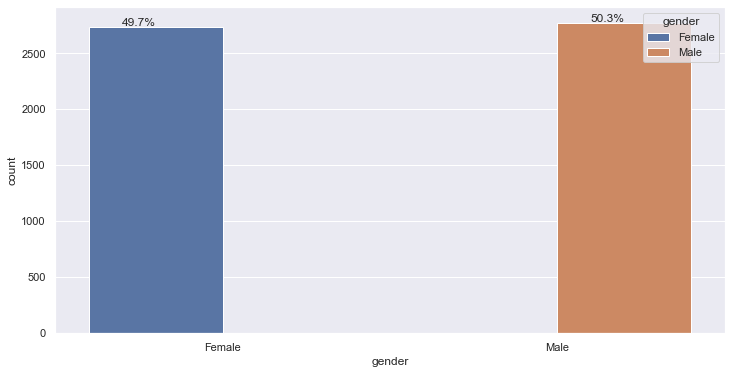

In [14]:
sns.set(rc = {'figure.figsize':(12,6)})

ax = sns.countplot(data = data, x = data.gender, hue = data.gender)

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/len(data)), (p.get_x()+0.1, p.get_height()+5))

About half of the customers in our dataset are male and the other half are female.

#### Senior Sitizen :

In [15]:
data.SeniorCitizen.value_counts()

0    4422
1    1090
Name: SeniorCitizen, dtype: int64

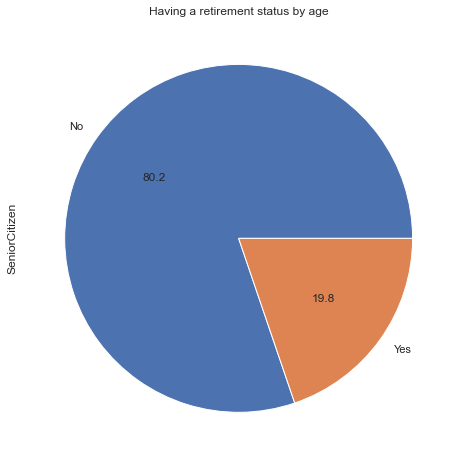

In [16]:
def autopct(pct): 
    return ('%.1f' % pct)
plt.figure(figsize = (6,6))
plt.title("Having a retirement status by age")
(data.SeniorCitizen.value_counts()*100/ len(data)).plot(kind = 'pie', figsize=(8, 8),y = 'SeniorCitizen',
                                                  autopct=autopct, labels=['No', 'Yes']);


Only about 20% of clients are pensioners. Thus, most of our clients in the data are young people.

#### Partner & Dependents :

In [17]:
data.Partner.value_counts()

No     2852
Yes    2660
Name: Partner, dtype: int64

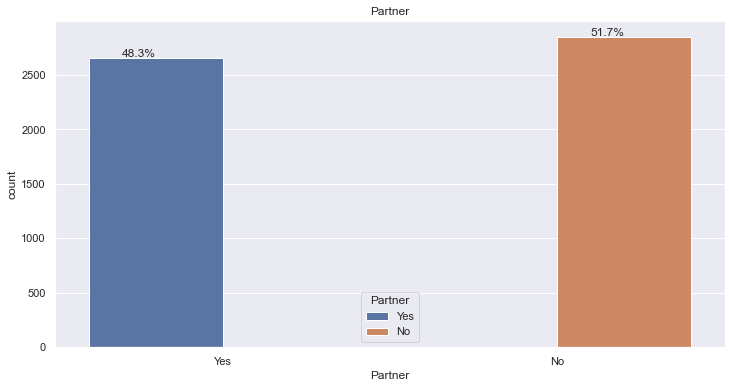

In [18]:
ax = sns.countplot(x = data['Partner'], hue = data['Partner'])
plt.title('Partner')

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/len(data)), (p.get_x()+0.1, p.get_height()+5))


In [19]:
data.Dependents.value_counts()

No     4050
Yes    1462
Name: Dependents, dtype: int64

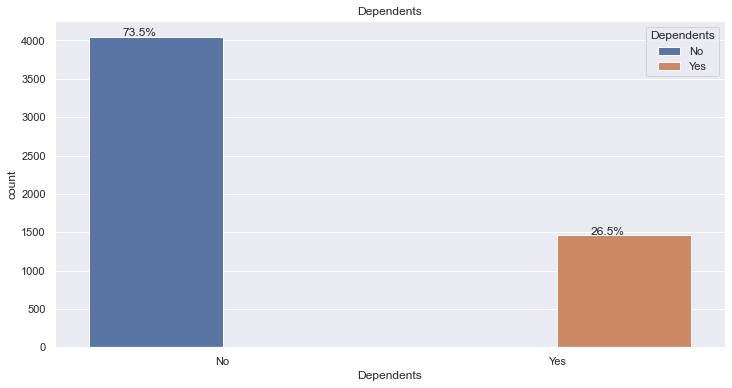

In [20]:
ax = sns.countplot(x = data['Dependents'], hue = data['Dependents'])
plt.title('Dependents')

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/len(data)), (p.get_x()+0.1, p.get_height()+5))

About 50% of clients have a partner, and only 26.5% of the total number of clients have dependents.

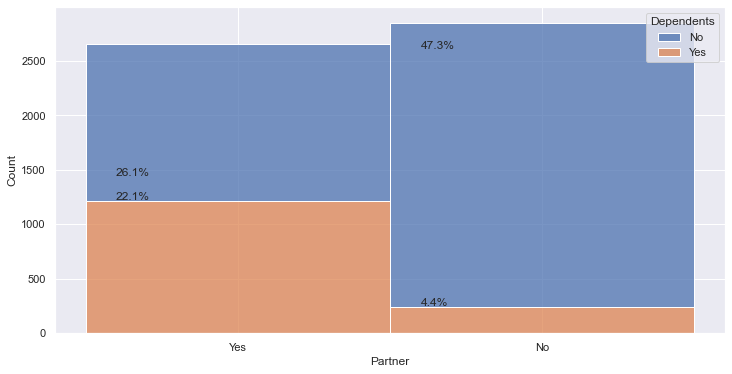

In [21]:
ax = sns.histplot(data = data, x = 'Partner', hue = 'Dependents', multiple="stack")
for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/len(data)), (p.get_x()+0.1, p.get_height()+5))

* About 22% of clients have a partner and have dependents.
* 26% - have a partner and do not have dependents.
* 47% of clients who do not have a partner and do not have dependents.
* And only 4.4% who do not have a partner and are not dependent on others.

#### Type : 

In [22]:
data.Type.value_counts()

Month-to-month    3351
One year          1109
Two year          1052
Name: Type, dtype: int64

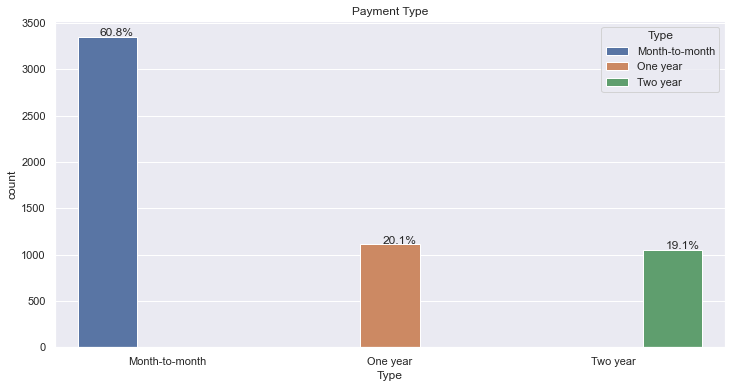

In [23]:
ax = sns.countplot(x = data['Type'], hue = data['Type'])
plt.title('Payment Type')

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/len(data)), (p.get_x()+0.1, p.get_height()+5))

As you can see from this graph, most clients enter into monthly contracts. While there is an equal number of clients in 1 year and 2 year contracts.

#### Paper less Billing  :

In [24]:
data.PaperlessBilling.value_counts()

Yes    3723
No     1789
Name: PaperlessBilling, dtype: int64

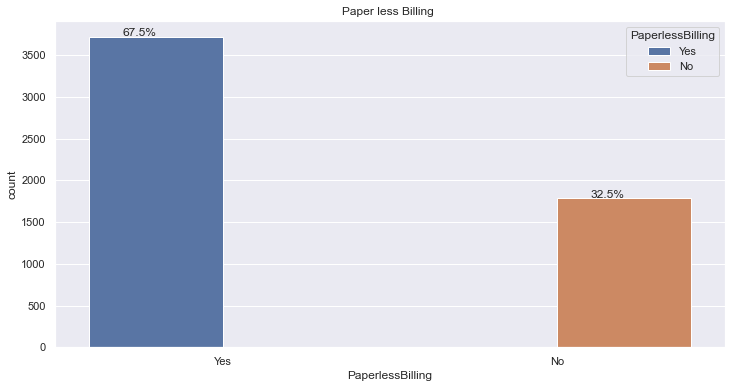

In [25]:
ax = sns.countplot(x = data['PaperlessBilling'], hue = data['PaperlessBilling'])
plt.title('Paper less Billing ')

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/len(data)), (p.get_x()+0.1, p.get_height()+5))

Almost 70% of users do not receive paper payments.

#### Payment Method:

In [26]:
data.PaymentMethod.value_counts()

Electronic check             2243
Bank transfer (automatic)    1210
Credit card (automatic)      1190
Mailed check                  869
Name: PaymentMethod, dtype: int64

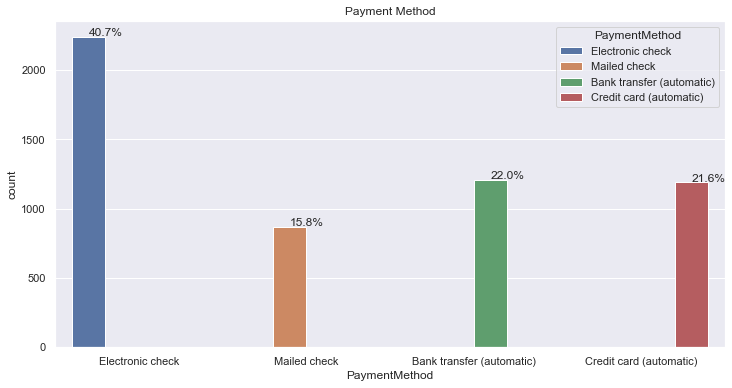

In [27]:
sns.set(rc = {'figure.figsize':(12,6)})

ax = sns.countplot(x = data['PaymentMethod'], hue = data['PaymentMethod'])
plt.title('Payment Method')
for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/len(data)), (p.get_x()+0.1, p.get_height()+5))

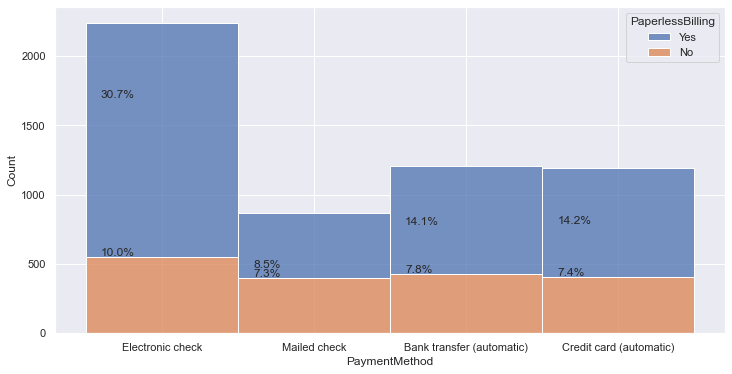

In [28]:
ax = sns.histplot(data = data, x = 'PaymentMethod', hue = 'PaperlessBilling', multiple="stack")
for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/len(data)), (p.get_x()+0.1, p.get_height()+5))

#### Services :

In [29]:
data.InternetService.value_counts()

Fiber optic    3096
DSL            2416
Name: InternetService, dtype: int64

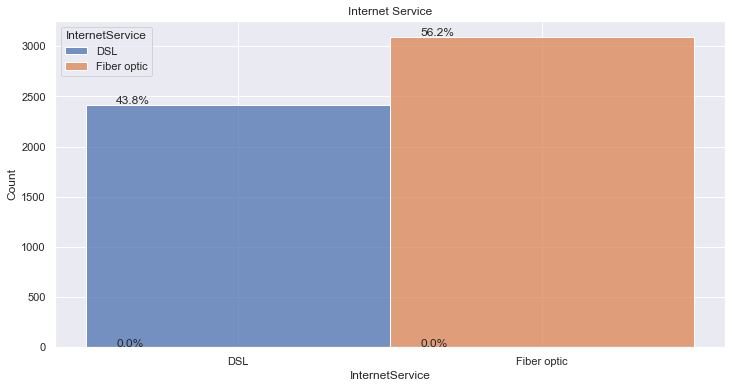

In [30]:
ax = sns.histplot(data = data, x = 'InternetService', hue = 'InternetService', multiple="stack")
plt.title('Internet Service')

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/len(data)), (p.get_x()+0.1, p.get_height()+5))

In [31]:
data.OnlineSecurity.value_counts()

No     3497
Yes    2015
Name: OnlineSecurity, dtype: int64

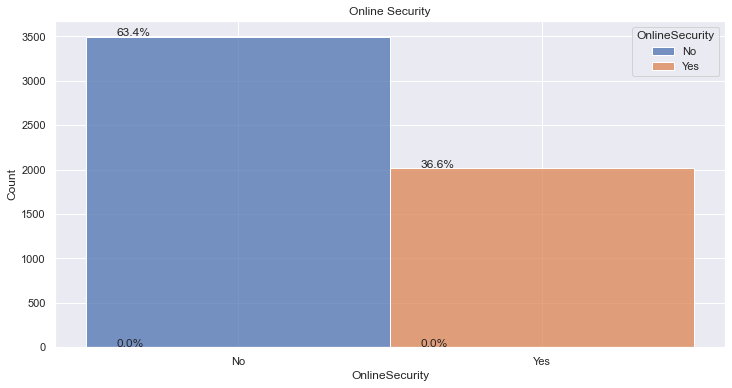

In [32]:
ax = sns.histplot(data = data, x = 'OnlineSecurity', hue = 'OnlineSecurity', multiple="stack")
plt.title('Online Security')

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/len(data)), (p.get_x()+0.1, p.get_height()+5))

In [33]:
data.OnlineBackup.value_counts()

No     3087
Yes    2425
Name: OnlineBackup, dtype: int64

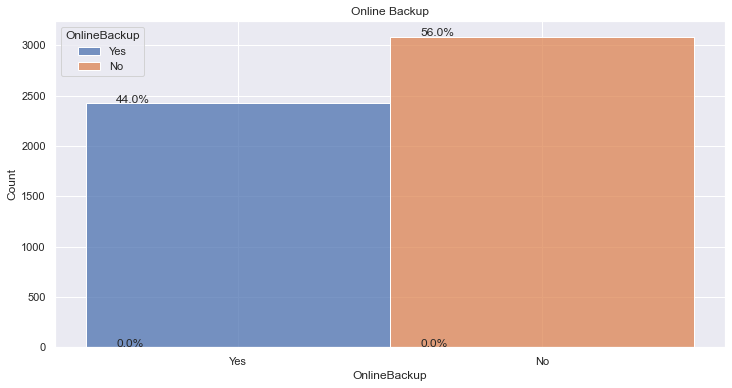

In [34]:
ax = sns.histplot(data = data, x = 'OnlineBackup', hue = 'OnlineBackup', multiple="stack")
plt.title('Online Backup')

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/len(data)), (p.get_x()+0.1, p.get_height()+5))

In [35]:
data.DeviceProtection.value_counts()

No     3094
Yes    2418
Name: DeviceProtection, dtype: int64

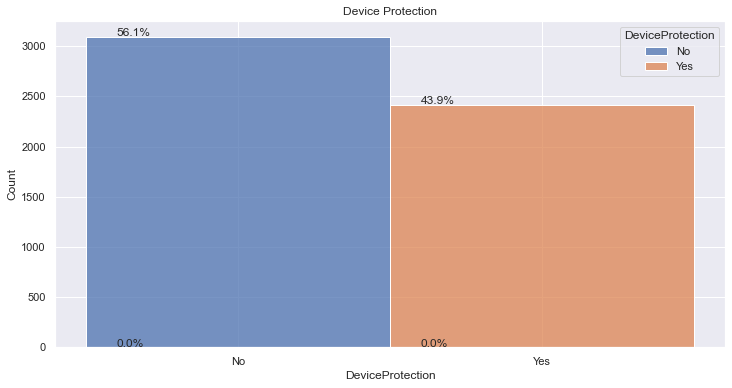

In [36]:
ax = sns.histplot(data = data, x = 'DeviceProtection', hue = 'DeviceProtection', multiple="stack")
plt.title('Device Protection')

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/len(data)), (p.get_x()+0.1, p.get_height()+5))

In [37]:
data.TechSupport.value_counts()

No     3472
Yes    2040
Name: TechSupport, dtype: int64

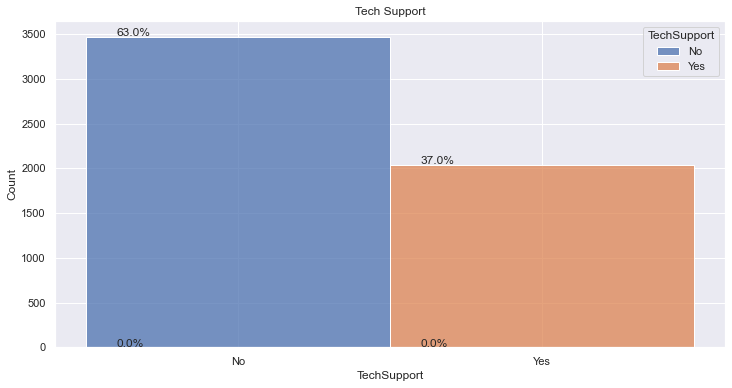

In [38]:
ax = sns.histplot(data = data, x = 'TechSupport', hue = 'TechSupport', multiple="stack")
plt.title('Tech Support')

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/len(data)), (p.get_x()+0.1, p.get_height()+5))

In [39]:
data.StreamingTV.value_counts()

No     2809
Yes    2703
Name: StreamingTV, dtype: int64

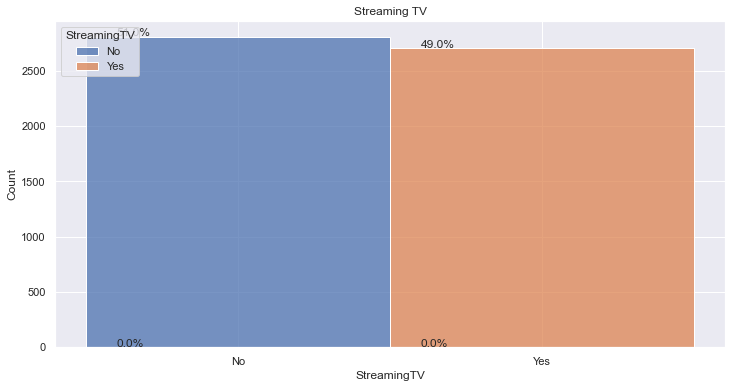

In [40]:
ax = sns.histplot(data = data, x = 'StreamingTV', hue = 'StreamingTV', multiple="stack")
plt.title('Streaming TV')

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/len(data)), (p.get_x()+0.1, p.get_height()+5))

In [41]:
data.StreamingMovies.value_counts()

No     2781
Yes    2731
Name: StreamingMovies, dtype: int64

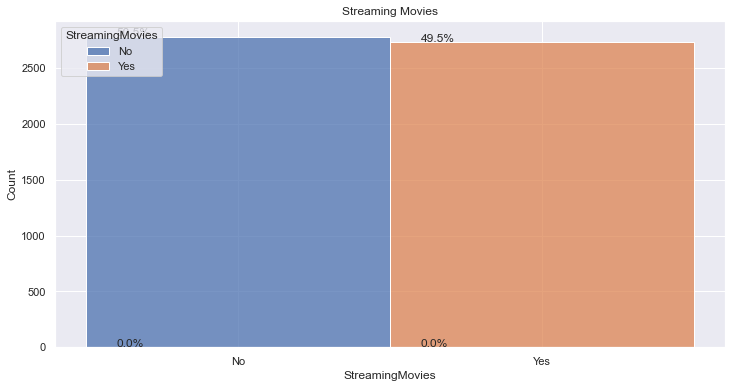

In [42]:
ax = sns.histplot(data = data, x = 'StreamingMovies', hue = 'StreamingMovies', multiple="stack")
plt.title('Streaming Movies')

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/len(data)), (p.get_x()+0.1, p.get_height()+5))

In [43]:
data.MultipleLines.value_counts()

Yes                 2627
No                  2205
No phone service     680
Name: MultipleLines, dtype: int64

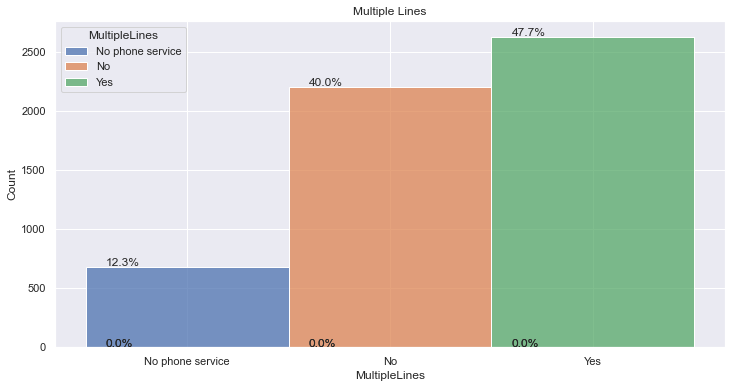

In [44]:
ax = sns.histplot(data = data, x = 'MultipleLines', hue = 'MultipleLines', multiple="stack")
plt.title('Multiple Lines')

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/len(data)), (p.get_x()+0.1, p.get_height()+5))

- Let's check <code>MonthlyCharges</code> and <code>TotalCharges</code> for outliers:

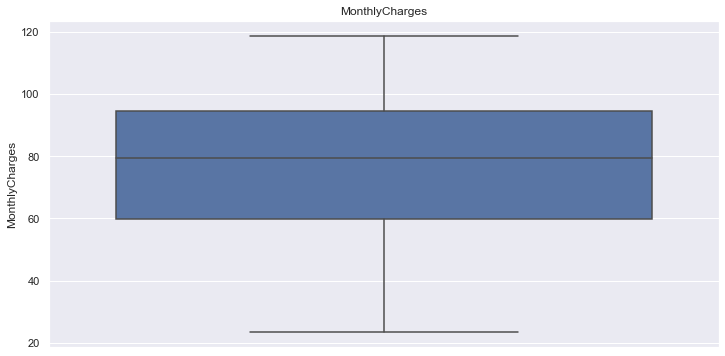

In [45]:
plt.title('MonthlyCharges')
sns.boxplot(y = 'MonthlyCharges',
                 data = data);


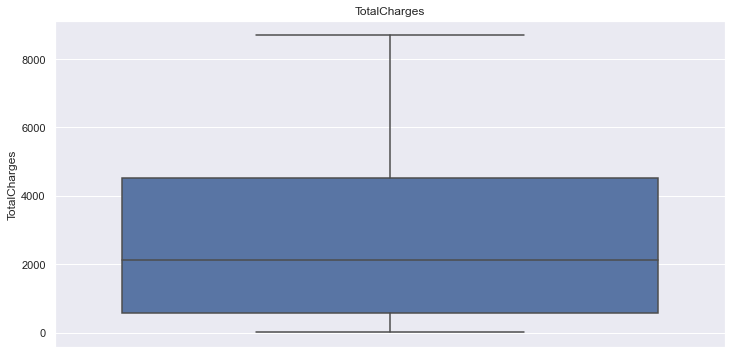

In [46]:
plt.title('TotalCharges')
sns.boxplot(y = 'TotalCharges',
                 data = data);

There are no emissions.

- Let's take a quick look at the relationship between monthly and total charges.

<AxesSubplot:xlabel='MonthlyCharges', ylabel='TotalCharges'>

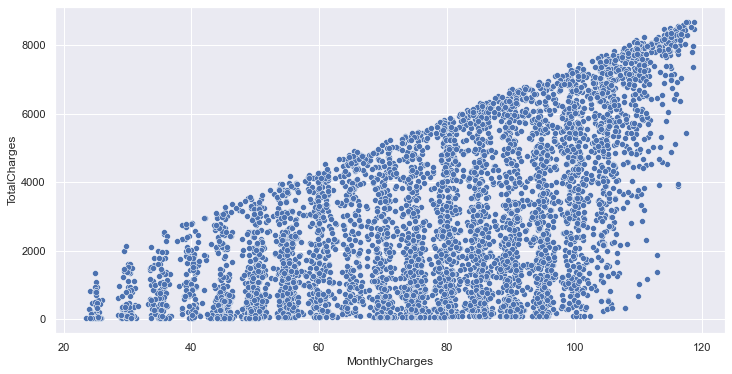

In [47]:
sns.scatterplot(x=data['MonthlyCharges'], y=data['TotalCharges'])

It can be seen that the total costs increase as the monthly bill for the client increases.

- Let's create a column that will say whether the client left or not. He will be the target in the future.

In [48]:
def churn_func(data):
    churn = data.EndDate
    if 'No' in churn :
        return 0 #the client didn't leave
    else:
        return 1 #the client leave
data['churn'] = data.apply(churn_func, axis = 1)    
    

In [49]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,...,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,churn
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,...,29.85,DSL,No,Yes,No,No,No,No,No phone service,0
1,5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,...,1889.50,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,...,108.15,DSL,Yes,Yes,No,No,No,No,No,1
3,7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),...,1840.75,DSL,Yes,No,Yes,Yes,No,No,No phone service,0
4,9237-HQITU,Female,0,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,...,151.65,Fiber optic,No,No,No,No,No,No,No,1


- Let's create a column in which the number of months during which the client remained in the company. For those customers who have not left, we will indicate the current date February 1, 2020.

In [50]:
data['EndDate'] = data['EndDate'].replace('No', '2020-02-01')

In [51]:
data['BeginDate'] = pd.to_datetime(data['BeginDate'], format='%Y-%m-%d')
data['EndDate'] = pd.to_datetime(data['EndDate'], format='%Y-%m-%d')

In [52]:
data['tenure'] = data['EndDate'] - data['BeginDate']
data['tenure'] = data['tenure'].astype('timedelta64[D]').astype('int')
data['tenure'].head()

0      31
1    1036
2      61
3    1371
4      61
Name: tenure, dtype: int64

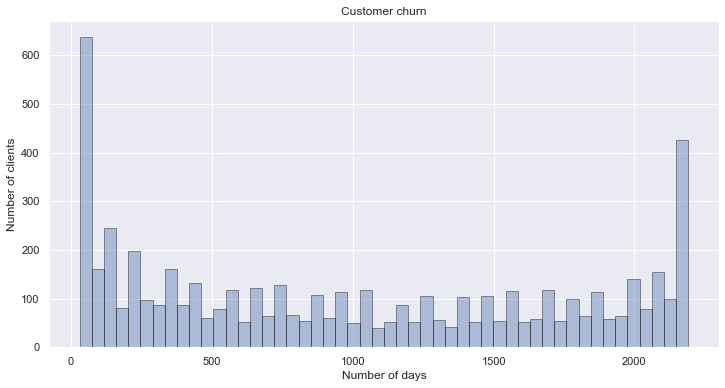

In [53]:
ax = sns.distplot(data['tenure'], hist = True, kde = False , bins= 50,
                 kde_kws={'linewidth': 4},
                 hist_kws={'edgecolor':'black'})
ax.set_title('Customer churn')
ax.set_ylabel('Number of clients')
ax.set_xlabel('Number of days');


We see that many clients work with a telecommunications company for only a month, while many work for about 72 months. This could potentially be due to different clients having different contracts. Thus, on the basis of the concluded contract, it may be more / less easier for customers to stay / leave the telecommunications company.

- Let's look at the tenure of a client depending on the type of their contract.

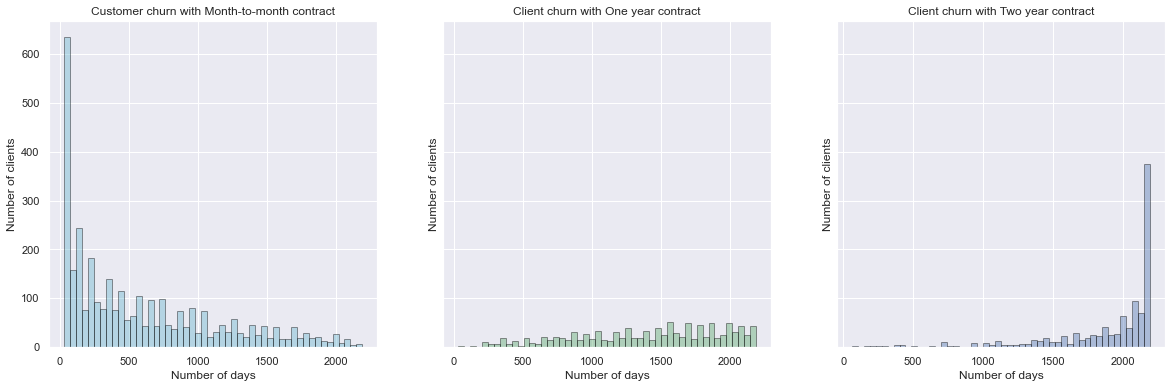

In [54]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, sharey = True, figsize = (20,6))

ax = sns.distplot(data[data['Type'] == 'Month-to-month']['tenure'], hist = True, kde = False , bins= 50,
                 kde_kws={'linewidth': 4},
                 hist_kws={'edgecolor':'black'},
                 color = 'c', ax = ax1)
ax.set_title('Customer churn with Month-to-month contract')
ax.set_ylabel('Number of clients')
ax.set_xlabel('Number of days')


ax = sns.distplot(data[data['Type'] == 'One year']['tenure'], hist = True, kde = False , bins= 50,
                 kde_kws={'linewidth': 4},
                 hist_kws={'edgecolor':'black'},
                 color = 'g', ax = ax2)
ax.set_title('Client churn with One year contract')
ax.set_ylabel('Number of clients')
ax.set_xlabel('Number of days')


ax = sns.distplot(data[data['Type'] == 'Two year']['tenure'], hist = True, kde = False , bins= 50,
                 kde_kws={'linewidth': 4},
                 hist_kws={'edgecolor':'black'},
                 color = 'b', ax = ax3)
ax.set_title('Client churn with Two year contract')
ax.set_ylabel('Number of clients')
ax.set_xlabel('Number of days');

Interestingly, most monthly contracts last 1-2 months, while two-year contracts tend to last around 70 months. This shows that customers with a longer contract are more loyal to the company and tend to stay with it for a longer period of time.

- Let's look at the churn rate in our data.

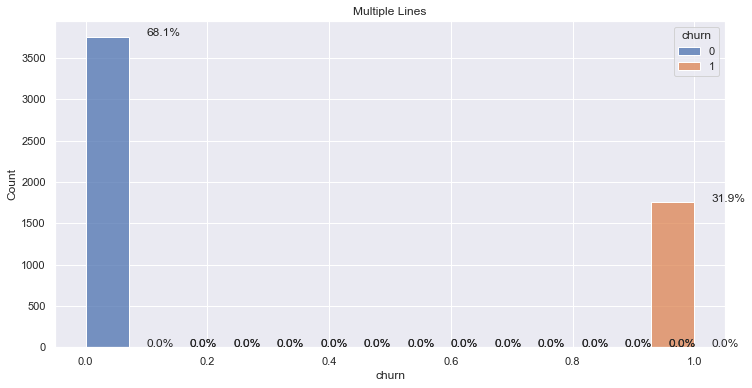

In [55]:
ax = sns.histplot(data = data, x = 'churn', hue = 'churn', multiple="stack")
plt.title('Multiple Lines')

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/len(data)), (p.get_x()+0.1, p.get_height()+5))


About 32% left.

- Let's look at the churn of customers depending on the type of their contract.

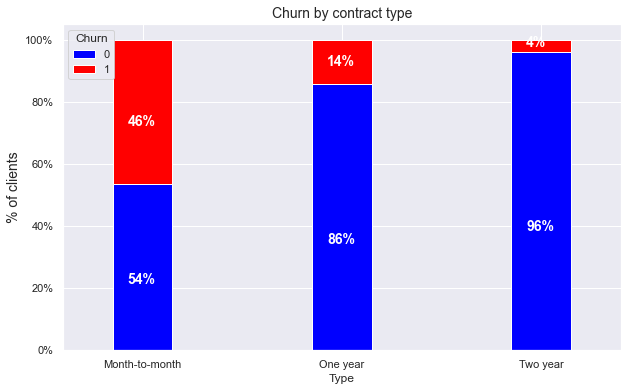

In [56]:
contract_churn = data.groupby(['Type','churn']).size().unstack()

ax = (contract_churn.T*100.0 / contract_churn.T.sum()).T.plot(kind='bar',
                                                                width = 0.3,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (10,6),
                                                                color = ['blue', 'red'])
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(title = 'Churn')
ax.set_ylabel('% of clients',size = 14)
ax.set_title('Churn by contract type',size = 14)

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',
               size = 14)

Clients who have a monthly contract have a very high churn rate.

- Monthly payment outflow

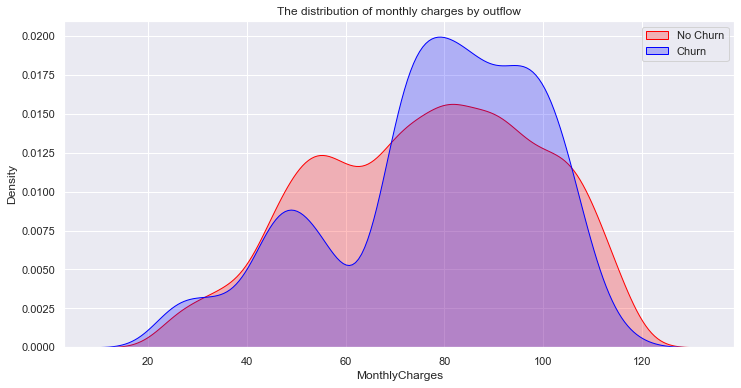

In [57]:
ax = sns.kdeplot(data[data['churn'] == 0]['MonthlyCharges'], color = 'Red', shade = True)
ax = sns.kdeplot(data[data['churn'] == 1]['MonthlyCharges'], color = 'Blue', shade = True, ax=ax)
ax.legend(['No Churn', 'Churn'])
ax.set_title('The distribution of monthly charges by outflow');

Higher churn rates when monthly payments are high.

- Churn on total expenses

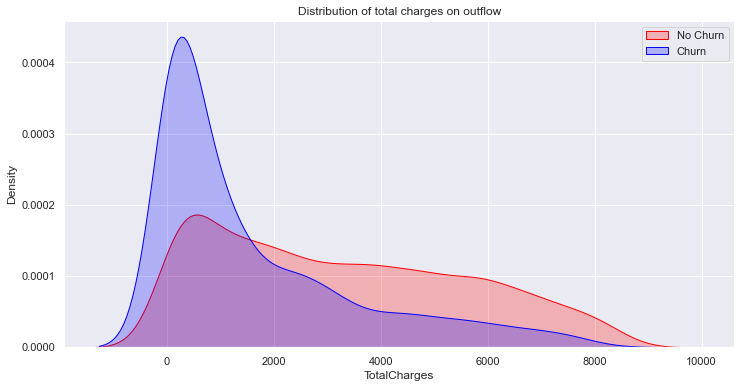

In [58]:
ax = sns.kdeplot(data[data['churn'] == 0]['TotalCharges'], color = 'Red', shade = True)
ax = sns.kdeplot(data[data['churn'] == 1]['TotalCharges'], color = 'Blue', shade = True, ax=ax)
ax.legend(['No Churn', 'Churn'])
ax.set_title('Distribution of total charges on outflow');

Higher churn rates when total payments are low.

In [59]:
data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'BeginDate', 'EndDate', 'Type', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'MultipleLines', 'churn', 'tenure'],
      dtype='object')

### Removing features

In [60]:
data = data.drop(['BeginDate', 'EndDate', 'customerID'], axis = 1)
data.head()

,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,churn,tenure
0,Female,0,Yes,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,No phone service,0,31
1,Male,0,No,No,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,Male,0,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,No,1,61
3,Male,0,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,No phone service,0,1371
4,Female,0,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,No,1,61


### Converting categorical features

In [61]:
data_ohe = pd.get_dummies(data, drop_first=True) 
data_ohe.head()

,SeniorCitizen,MonthlyCharges,TotalCharges,churn,tenure,gender_Male,Partner_Yes,Dependents_Yes,Type_One year,Type_Two year,...,PaymentMethod_Mailed check,InternetService_Fiber optic,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_No phone service,MultipleLines_Yes
0,0,29.85,29.85,0,31,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,56.95,1889.50,0,1036,1,0,0,1,0,...,1,0,1,0,1,0,0,0,0,0
2,0,53.85,108.15,1,61,1,0,0,0,0,...,1,0,1,1,0,0,0,0,0,0
3,0,42.30,1840.75,0,1371,1,0,0,1,0,...,0,0,1,0,1,1,0,0,1,0
4,0,70.70,151.65,1,61,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


- Let's see how customer churn correlates with other signs

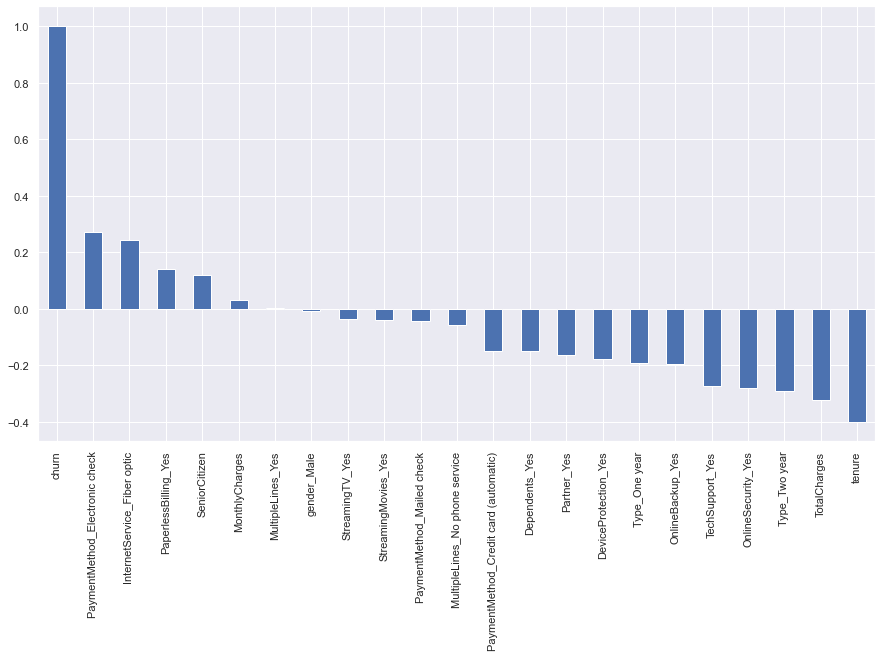

In [62]:
plt.figure(figsize=(15,8))
data_ohe.corr()['churn'].sort_values(ascending = False).plot(kind = 'bar');


Payment Method by electronic check, paper less billing and senior citizen are positively correlated with churn. While tenure, total spending and two year contract are negatively correlated with churn.

### Let's divide the data into samples:

In [63]:
features = data_ohe.drop('churn', axis = 1)
target = data_ohe['churn']



- Let's do feature scaling

In [64]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.3, random_state=12345)



In [65]:
features_train.shape

(3858, 22)

In [66]:
features_test.shape

(1654, 22)

In [67]:
features_train.head()

,SeniorCitizen,MonthlyCharges,TotalCharges,tenure,gender_Male,Partner_Yes,Dependents_Yes,Type_One year,Type_Two year,PaperlessBilling_Yes,...,PaymentMethod_Mailed check,InternetService_Fiber optic,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_No phone service,MultipleLines_Yes
2065,0,70.70,140.70,61,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3774,1,33.45,1500.25,1310,0,0,0,0,0,1,...,0,0,1,1,0,0,0,0,1,0
3968,0,40.60,1494.50,1187,1,0,0,0,0,1,...,0,0,0,0,0,1,0,1,1,0
1931,1,99.95,3186.65,944,0,0,0,0,0,1,...,0,1,0,1,0,0,1,1,0,1
5390,0,43.95,43.95,30,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [68]:
target_train.head()

2065    1
3774    0
3968    0
1931    1
5390    1
Name: churn, dtype: int64

## Let's train models
To solve the classification problem, consider the following studied models:
* DTC decision tree
* RFC random forest
* LRC logistic regression
* k-nearest neighbor method kNN
* LGBM Boost
* Cat Boost

### Decision Tree 

- Using <code>RandomSearchCV</code> and <code>GridSearchCV</code> we will select the best hyperparameters. We will evaluate the quality of the model using the metric F1

In [69]:
DecisionTreeClassifier().get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [70]:
%%time
dtc_model = DecisionTreeClassifier(random_state = 12345)

dtc_randomized_param = {
    'max_depth': range(1,250),
    'min_samples_leaf': range(1,250),
    'criterion': ['entropy', 'gini'] 
}

dtc_randomized_search = RandomizedSearchCV(dtc_model, dtc_randomized_param, n_iter=100, cv=5, n_jobs=-1,
                               scoring='f1', return_train_score=True, random_state=12345)

dtc_randomized_search.fit(features_train, target_train)

CPU times: user 569 ms, sys: 183 ms, total: 752 ms
Wall time: 3.13 s


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=12345),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': range(1, 250),
                                        'min_samples_leaf': range(1, 250)},
                   random_state=12345, return_train_score=True, scoring='f1')

In [71]:
print('Best F1 score: {}'
      .format(dtc_randomized_search.best_score_))
print('Best parameters: {}'
      .format(dtc_randomized_search.best_params_))

Best F1 score: 0.6101124309394519
Best parameters: {'min_samples_leaf': 15, 'max_depth': 174, 'criterion': 'entropy'}


We have obtained hyperparameters, but their estimate is rather rough. That is, we know the invalid value of the hyperparameter, the interval in which this value will cover.

Now we will perform a more accurate search for the values of hyperparameters

In [72]:
%%time
dtc_param_grid = {
    'max_depth': range(160,190), 
    'min_samples_leaf': range(5,25),
    'criterion': ['entropy']
}

dtc_grid_search = GridSearchCV(dtc_model, dtc_param_grid, cv=5, n_jobs=-1,
                               scoring='f1', return_train_score=True)

dtc_grid_search.fit(features_train, target_train)

CPU times: user 1.79 s, sys: 156 ms, total: 1.94 s
Wall time: 8.63 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=12345),
             n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': range(160, 190),
                         'min_samples_leaf': range(5, 25)},
             return_train_score=True, scoring='f1')

In [73]:
print('Best F1 score: {}'
      .format(dtc_grid_search.best_score_))
print('Best parameters: {}'
      .format(dtc_grid_search.best_params_))

Best F1 score: 0.6141046377583717
Best parameters: {'criterion': 'entropy', 'max_depth': 160, 'min_samples_leaf': 7}


Let's calculate the remaining metrics for this model. First, let's write a function that would take a classifier and data as input, and return a dataframe with metrics

In [74]:
def result_metrics(estimator, x, y, column_name):
    
    cv_results = cross_validate(estimator, x, y, cv=6,
                                scoring=('accuracy', 'precision', 'recall', 'f1'),
                                return_train_score=True)
    roc_auc_cv = cross_val_score(estimator, x, y, cv=6, scoring='roc_auc')

    cv_metrics_dict = {'Accuracy': cv_results['test_accuracy'].mean(),
                       'Precision': cv_results['test_precision'].mean(),
                       'Recall': cv_results['test_recall'].mean(),
                       'F1': cv_results['test_f1'].mean(),
                       'AUC-ROC': roc_auc_cv.mean()
                      }
    return pd.DataFrame.from_dict(cv_metrics_dict, orient='index', columns=[column_name])

In [75]:
best_dtc = DecisionTreeClassifier(random_state=12345,
                                  max_depth=160,
                                  min_samples_leaf=7,
                                  criterion='entropy')
                                  

dtc_metrics = result_metrics(best_dtc, features_train, target_train, 'DTC')
dtc_metrics

,DTC
Accuracy,0.747019
Precision,0.616037
Recall,0.574353
F1,0.594124
AUC-ROC,0.776390


### Random Forest

- Using <code>RandomSearchCV</code> and <code>GridSearchCV</code> we will select the best hyperparameters. We will evaluate the quality of the model using the metric F1

In [76]:
%%time
rfc_model = RandomForestClassifier(random_state = 12345)

rfc_randomized_param = {'max_depth': range(1,200),
                       'n_estimators' : range(1,200)}
rfc_randomized_search = RandomizedSearchCV(rfc_model, rfc_randomized_param, n_iter = 100, 
                                          cv = 6 , n_jobs = -1, scoring = 'f1',
                                           return_train_score=True, random_state=12345)
rfc_randomized_search.fit(features_train, target_train)

CPU times: user 1.65 s, sys: 171 ms, total: 1.82 s
Wall time: 36 s


RandomizedSearchCV(cv=6, estimator=RandomForestClassifier(random_state=12345),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': range(1, 200),
                                        'n_estimators': range(1, 200)},
                   random_state=12345, return_train_score=True, scoring='f1')

In [77]:
print('Best F1 score: {}'
      .format(rfc_randomized_search.best_score_))
print('Best parameters: {}'
      .format(rfc_randomized_search.best_params_))

Best F1 score: 0.6217591101597076
Best parameters: {'n_estimators': 91, 'max_depth': 9}


In [78]:
%%time
rfc_param_grid = {
    'n_estimators': range(85,110),
    'max_depth': range(1,25)
}

rfc_grid_search = GridSearchCV(rfc_model, rfc_param_grid, cv=6, n_jobs=-1,
                               scoring='f1', return_train_score=True)
rfc_grid_search.fit(features_train, target_train)

CPU times: user 7.59 s, sys: 863 ms, total: 8.45 s
Wall time: 3min 4s


GridSearchCV(cv=6, estimator=RandomForestClassifier(random_state=12345),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 25),
                         'n_estimators': range(85, 110)},
             return_train_score=True, scoring='f1')

In [79]:
print('Best F1 score: {}'
      .format(rfc_grid_search.best_score_))
print('Best parameters: {}'
      .format(rfc_grid_search.best_params_))

Best F1 score: 0.6249843810471396
Best parameters: {'max_depth': 10, 'n_estimators': 107}


In [80]:
best_rfc = RandomForestClassifier(random_state=12345,
                                  max_depth=10,
                                  n_estimators=107)

rfc_metrics = result_metrics(best_rfc, features_train, target_train, 'RFC')
rfc_metrics

,RFC
Accuracy,0.786677
Precision,0.724629
Recall,0.551805
F1,0.624984
AUC-ROC,0.833125


### Logistic Regression

In [81]:
LogisticRegression().get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

- Let's scale

In [82]:
column = features_train.columns
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(features_train)

features_train_scaled = scaler.transform(features_train)
features_test_scaled = scaler.transform(features_test)

features_train.columns = column
features_train.head()

,SeniorCitizen,MonthlyCharges,TotalCharges,tenure,gender_Male,Partner_Yes,Dependents_Yes,Type_One year,Type_Two year,PaperlessBilling_Yes,...,PaymentMethod_Mailed check,InternetService_Fiber optic,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_No phone service,MultipleLines_Yes
2065,0,70.70,140.70,61,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3774,1,33.45,1500.25,1310,0,0,0,0,0,1,...,0,0,1,1,0,0,0,0,1,0
3968,0,40.60,1494.50,1187,1,0,0,0,0,1,...,0,0,0,0,0,1,0,1,1,0
1931,1,99.95,3186.65,944,0,0,0,0,0,1,...,0,1,0,1,0,0,1,1,0,1
5390,0,43.95,43.95,30,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [83]:
%%time
logist_model = LogisticRegression(random_state = 12345, solver='liblinear')


logist_param = {'C':  range(-5,5),
                'max_iter' : [10,50,100],
               'fit_intercept': [True, False],
               'warm_start': [True, False],
               'dual': [True, False]}
logist_grid = GridSearchCV(logist_model ,logist_param, n_jobs = -1, cv = 5, verbose = 0,
                          scoring = 'f1', return_train_score=True)
logist_grid.fit(features_train_scaled, target_train)

CPU times: user 467 ms, sys: 87.5 ms, total: 554 ms
Wall time: 1.56 s


GridSearchCV(cv=5,
             estimator=LogisticRegression(random_state=12345,
                                          solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': range(-5, 5), 'dual': [True, False],
                         'fit_intercept': [True, False],
                         'max_iter': [10, 50, 100],
                         'warm_start': [True, False]},
             return_train_score=True, scoring='f1')

In [84]:
print('Best F1 score: {}'
      .format(logist_grid.best_score_))
print('Best parameters: {}'
      .format(logist_grid.best_params_))

Best F1 score: 0.6194902980250083
Best parameters: {'C': 3, 'dual': True, 'fit_intercept': False, 'max_iter': 10, 'warm_start': True}


In [85]:
best_logistic = LogisticRegression(random_state=12345,
                                  solver='liblinear',
                                  C = 3, dual = True, 
                                 fit_intercept = False, 
                                 max_iter = 10, warm_start = True)
                                  

lrc_metrics = result_metrics(best_logistic, features_train_scaled, target_train, 'LRC')
lrc_metrics

,LRC
Accuracy,0.762830
Precision,0.650417
Recall,0.579126
F1,0.611711
AUC-ROC,0.818643


### k-nearest neighbor method

For this method, we will select the number of neighbors k

In [86]:
KNeighborsClassifier().get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [87]:
knn_model = KNeighborsClassifier()

knn_param_grid = {
    'n_neighbors': range(1,10)
}
knn_grid_search = GridSearchCV(knn_model, knn_param_grid, n_jobs = -1, cv = 6, 
                              scoring = 'f1', return_train_score=True)
knn_grid_search.fit(features_train_scaled, target_train)

GridSearchCV(cv=6, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': range(1, 10)}, return_train_score=True,
             scoring='f1')

In [88]:
print('Best F1 score: {}'
      .format(knn_grid_search.best_score_))
print('Best parameters: {}'
      .format(knn_grid_search.best_params_))

Best F1 score: 0.5826384211973402
Best parameters: {'n_neighbors': 9}


In [89]:
best_knn = KNeighborsClassifier(n_neighbors = 9)

knn_metrics = result_metrics(best_knn, features_train_scaled, target_train, 'kNN')
knn_metrics

,kNN
Accuracy,0.731467
Precision,0.585721
Recall,0.580689
F1,0.582638
AUC-ROC,0.774751


### CatBoost

In [90]:
cat_model = CatBoostClassifier()

cat_params = {'depth': range(1,10),
             'iterations' : [1,10,25,50,100,200],
             'learning_rate' : [0.01, 0.05, 0.1]}
cat_grid = GridSearchCV(cat_model, cat_params , n_jobs= -1, scoring = 'f1')
cat_grid.fit(features_train_scaled, target_train)

0:	learn: 0.6489020	total: 60.5ms	remaining: 12s
1:	learn: 0.6137753	total: 62.1ms	remaining: 6.14s
2:	learn: 0.5873880	total: 63.7ms	remaining: 4.18s
3:	learn: 0.5627102	total: 65.1ms	remaining: 3.19s
4:	learn: 0.5457440	total: 66.6ms	remaining: 2.6s
5:	learn: 0.5336532	total: 68.8ms	remaining: 2.22s
6:	learn: 0.5170956	total: 70.3ms	remaining: 1.94s
7:	learn: 0.5072425	total: 71.5ms	remaining: 1.72s
8:	learn: 0.4985981	total: 72.8ms	remaining: 1.54s
9:	learn: 0.4882646	total: 74.8ms	remaining: 1.42s
10:	learn: 0.4823014	total: 76.8ms	remaining: 1.32s
11:	learn: 0.4758970	total: 78.4ms	remaining: 1.23s
12:	learn: 0.4704555	total: 80.4ms	remaining: 1.16s
13:	learn: 0.4669727	total: 81.9ms	remaining: 1.09s
14:	learn: 0.4611971	total: 83.1ms	remaining: 1.02s
15:	learn: 0.4590400	total: 85.2ms	remaining: 980ms
16:	learn: 0.4559914	total: 86.9ms	remaining: 935ms
17:	learn: 0.4532891	total: 88ms	remaining: 890ms
18:	learn: 0.4499074	total: 89.6ms	remaining: 854ms
19:	learn: 0.4467653	total:

GridSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x7fd5502451f0>,
             n_jobs=-1,
             param_grid={'depth': range(1, 10),
                         'iterations': [1, 10, 25, 50, 100, 200],
                         'learning_rate': [0.01, 0.05, 0.1]},
             scoring='f1')

In [91]:
print('Best F1 score: {}'
      .format(cat_grid.best_score_))
print('Best parameters: {}'
      .format(cat_grid.best_params_))

Best F1 score: 0.6817970346008246
Best parameters: {'depth': 5, 'iterations': 200, 'learning_rate': 0.1}


In [92]:
best_cat = CatBoostClassifier(depth = 5,
                             iterations = 200, learning_rate = 0.1)

cat_metrics = result_metrics(best_cat, features_train_scaled, target_train, 'Cat Boost')
cat_metrics

0:	learn: 0.6472943	total: 2.63ms	remaining: 524ms
1:	learn: 0.6126192	total: 3.64ms	remaining: 360ms
2:	learn: 0.5858359	total: 4.55ms	remaining: 299ms
3:	learn: 0.5640195	total: 5.24ms	remaining: 257ms
4:	learn: 0.5451079	total: 6.25ms	remaining: 244ms
5:	learn: 0.5305336	total: 7.18ms	remaining: 232ms
6:	learn: 0.5193389	total: 8.08ms	remaining: 223ms
7:	learn: 0.5047694	total: 9.15ms	remaining: 220ms
8:	learn: 0.4957372	total: 10.6ms	remaining: 224ms
9:	learn: 0.4896279	total: 11.7ms	remaining: 222ms
10:	learn: 0.4828691	total: 12.7ms	remaining: 218ms
11:	learn: 0.4773342	total: 13.7ms	remaining: 214ms
12:	learn: 0.4724060	total: 14.8ms	remaining: 214ms
13:	learn: 0.4679032	total: 15.9ms	remaining: 211ms
14:	learn: 0.4650099	total: 17.1ms	remaining: 211ms
15:	learn: 0.4602252	total: 18.6ms	remaining: 213ms
16:	learn: 0.4583252	total: 20.1ms	remaining: 216ms
17:	learn: 0.4559861	total: 21.3ms	remaining: 216ms
18:	learn: 0.4520345	total: 22.7ms	remaining: 216ms
19:	learn: 0.4489471	t

159:	learn: 0.3259061	total: 195ms	remaining: 48.7ms
160:	learn: 0.3254974	total: 196ms	remaining: 47.5ms
161:	learn: 0.3247379	total: 197ms	remaining: 46.3ms
162:	learn: 0.3239127	total: 199ms	remaining: 45.1ms
163:	learn: 0.3235876	total: 200ms	remaining: 43.8ms
164:	learn: 0.3230490	total: 201ms	remaining: 42.6ms
165:	learn: 0.3224553	total: 202ms	remaining: 41.4ms
166:	learn: 0.3220043	total: 203ms	remaining: 40.2ms
167:	learn: 0.3213521	total: 205ms	remaining: 39ms
168:	learn: 0.3195024	total: 206ms	remaining: 37.8ms
169:	learn: 0.3191259	total: 207ms	remaining: 36.6ms
170:	learn: 0.3186338	total: 209ms	remaining: 35.4ms
171:	learn: 0.3180453	total: 210ms	remaining: 34.2ms
172:	learn: 0.3172959	total: 211ms	remaining: 33ms
173:	learn: 0.3170990	total: 212ms	remaining: 31.7ms
174:	learn: 0.3165955	total: 214ms	remaining: 30.5ms
175:	learn: 0.3162404	total: 215ms	remaining: 29.3ms
176:	learn: 0.3157996	total: 216ms	remaining: 28.1ms
177:	learn: 0.3154360	total: 218ms	remaining: 26.9

154:	learn: 0.3328569	total: 190ms	remaining: 55.2ms
155:	learn: 0.3324931	total: 192ms	remaining: 54ms
156:	learn: 0.3319731	total: 193ms	remaining: 52.8ms
157:	learn: 0.3316771	total: 194ms	remaining: 51.6ms
158:	learn: 0.3308663	total: 195ms	remaining: 50.3ms
159:	learn: 0.3305477	total: 196ms	remaining: 49.1ms
160:	learn: 0.3301474	total: 198ms	remaining: 47.9ms
161:	learn: 0.3297754	total: 199ms	remaining: 46.6ms
162:	learn: 0.3291531	total: 200ms	remaining: 45.4ms
163:	learn: 0.3286791	total: 201ms	remaining: 44.2ms
164:	learn: 0.3280781	total: 202ms	remaining: 42.9ms
165:	learn: 0.3273284	total: 204ms	remaining: 41.7ms
166:	learn: 0.3267971	total: 205ms	remaining: 40.5ms
167:	learn: 0.3262237	total: 206ms	remaining: 39.3ms
168:	learn: 0.3258395	total: 208ms	remaining: 38.1ms
169:	learn: 0.3251307	total: 209ms	remaining: 36.8ms
170:	learn: 0.3242384	total: 210ms	remaining: 35.6ms
171:	learn: 0.3235416	total: 211ms	remaining: 34.4ms
172:	learn: 0.3232348	total: 212ms	remaining: 33

159:	learn: 0.3159919	total: 195ms	remaining: 48.7ms
160:	learn: 0.3152636	total: 196ms	remaining: 47.5ms
161:	learn: 0.3144283	total: 197ms	remaining: 46.3ms
162:	learn: 0.3131105	total: 199ms	remaining: 45.1ms
163:	learn: 0.3125190	total: 200ms	remaining: 43.8ms
164:	learn: 0.3116342	total: 201ms	remaining: 42.6ms
165:	learn: 0.3109075	total: 202ms	remaining: 41.4ms
166:	learn: 0.3097609	total: 203ms	remaining: 40.2ms
167:	learn: 0.3094011	total: 204ms	remaining: 38.9ms
168:	learn: 0.3088936	total: 206ms	remaining: 37.7ms
169:	learn: 0.3070977	total: 207ms	remaining: 36.5ms
170:	learn: 0.3065658	total: 208ms	remaining: 35.3ms
171:	learn: 0.3061755	total: 209ms	remaining: 34.1ms
172:	learn: 0.3055199	total: 211ms	remaining: 32.9ms
173:	learn: 0.3043395	total: 212ms	remaining: 31.7ms
174:	learn: 0.3039960	total: 213ms	remaining: 30.5ms
175:	learn: 0.3031503	total: 215ms	remaining: 29.3ms
176:	learn: 0.3027700	total: 216ms	remaining: 28ms
177:	learn: 0.3024470	total: 217ms	remaining: 26

152:	learn: 0.3259629	total: 192ms	remaining: 58.9ms
153:	learn: 0.3251669	total: 195ms	remaining: 58.1ms
154:	learn: 0.3242839	total: 197ms	remaining: 57ms
155:	learn: 0.3237870	total: 198ms	remaining: 55.7ms
156:	learn: 0.3230337	total: 199ms	remaining: 54.4ms
157:	learn: 0.3223055	total: 200ms	remaining: 53.3ms
158:	learn: 0.3217977	total: 202ms	remaining: 52ms
159:	learn: 0.3206528	total: 203ms	remaining: 50.8ms
160:	learn: 0.3196718	total: 205ms	remaining: 49.6ms
161:	learn: 0.3190685	total: 206ms	remaining: 48.3ms
162:	learn: 0.3188019	total: 207ms	remaining: 47.1ms
163:	learn: 0.3184470	total: 209ms	remaining: 45.8ms
164:	learn: 0.3174415	total: 211ms	remaining: 44.7ms
165:	learn: 0.3169963	total: 212ms	remaining: 43.5ms
166:	learn: 0.3165101	total: 213ms	remaining: 42.2ms
167:	learn: 0.3159355	total: 215ms	remaining: 41ms
168:	learn: 0.3155632	total: 216ms	remaining: 39.7ms
169:	learn: 0.3146811	total: 218ms	remaining: 38.5ms
170:	learn: 0.3143277	total: 220ms	remaining: 37.3ms

155:	learn: 0.3246856	total: 193ms	remaining: 54.3ms
156:	learn: 0.3241407	total: 194ms	remaining: 53.1ms
157:	learn: 0.3236668	total: 195ms	remaining: 51.9ms
158:	learn: 0.3227587	total: 196ms	remaining: 50.7ms
159:	learn: 0.3223017	total: 198ms	remaining: 49.4ms
160:	learn: 0.3220149	total: 199ms	remaining: 48.2ms
161:	learn: 0.3213831	total: 200ms	remaining: 46.9ms
162:	learn: 0.3209907	total: 201ms	remaining: 45.7ms
163:	learn: 0.3204769	total: 203ms	remaining: 44.5ms
164:	learn: 0.3199422	total: 204ms	remaining: 43.2ms
165:	learn: 0.3193522	total: 205ms	remaining: 42ms
166:	learn: 0.3190264	total: 206ms	remaining: 40.8ms
167:	learn: 0.3185606	total: 207ms	remaining: 39.5ms
168:	learn: 0.3181179	total: 209ms	remaining: 38.2ms
169:	learn: 0.3178200	total: 210ms	remaining: 37ms
170:	learn: 0.3163967	total: 211ms	remaining: 35.8ms
171:	learn: 0.3155239	total: 213ms	remaining: 34.6ms
172:	learn: 0.3148884	total: 214ms	remaining: 33.4ms
173:	learn: 0.3146114	total: 215ms	remaining: 32.1

125:	learn: 0.3413742	total: 169ms	remaining: 99.3ms
126:	learn: 0.3400333	total: 171ms	remaining: 98.3ms
127:	learn: 0.3396100	total: 173ms	remaining: 97.5ms
128:	learn: 0.3385745	total: 175ms	remaining: 96.3ms
129:	learn: 0.3382162	total: 177ms	remaining: 95.2ms
130:	learn: 0.3375217	total: 179ms	remaining: 94.1ms
131:	learn: 0.3364126	total: 180ms	remaining: 92.9ms
132:	learn: 0.3357612	total: 182ms	remaining: 91.5ms
133:	learn: 0.3353208	total: 183ms	remaining: 90.3ms
134:	learn: 0.3348734	total: 185ms	remaining: 89ms
135:	learn: 0.3345318	total: 186ms	remaining: 87.5ms
136:	learn: 0.3340368	total: 187ms	remaining: 86ms
137:	learn: 0.3334273	total: 188ms	remaining: 84.5ms
138:	learn: 0.3321707	total: 190ms	remaining: 83.2ms
139:	learn: 0.3314865	total: 191ms	remaining: 81.8ms
140:	learn: 0.3308076	total: 192ms	remaining: 80.3ms
141:	learn: 0.3301929	total: 193ms	remaining: 79ms
142:	learn: 0.3298313	total: 195ms	remaining: 77.6ms
143:	learn: 0.3290017	total: 196ms	remaining: 76.2ms

83:	learn: 0.3838174	total: 105ms	remaining: 145ms
84:	learn: 0.3830111	total: 107ms	remaining: 144ms
85:	learn: 0.3826223	total: 108ms	remaining: 143ms
86:	learn: 0.3814737	total: 109ms	remaining: 142ms
87:	learn: 0.3809089	total: 111ms	remaining: 141ms
88:	learn: 0.3784877	total: 112ms	remaining: 140ms
89:	learn: 0.3780047	total: 113ms	remaining: 138ms
90:	learn: 0.3766037	total: 114ms	remaining: 137ms
91:	learn: 0.3760199	total: 116ms	remaining: 136ms
92:	learn: 0.3747387	total: 117ms	remaining: 135ms
93:	learn: 0.3743067	total: 118ms	remaining: 133ms
94:	learn: 0.3736561	total: 120ms	remaining: 132ms
95:	learn: 0.3733525	total: 121ms	remaining: 131ms
96:	learn: 0.3723061	total: 122ms	remaining: 129ms
97:	learn: 0.3713347	total: 123ms	remaining: 128ms
98:	learn: 0.3703022	total: 124ms	remaining: 127ms
99:	learn: 0.3698690	total: 126ms	remaining: 126ms
100:	learn: 0.3692789	total: 127ms	remaining: 124ms
101:	learn: 0.3682340	total: 128ms	remaining: 123ms
102:	learn: 0.3676700	total: 

84:	learn: 0.3857236	total: 102ms	remaining: 137ms
85:	learn: 0.3851746	total: 103ms	remaining: 137ms
86:	learn: 0.3845821	total: 104ms	remaining: 135ms
87:	learn: 0.3840617	total: 106ms	remaining: 134ms
88:	learn: 0.3833321	total: 107ms	remaining: 133ms
89:	learn: 0.3821452	total: 108ms	remaining: 132ms
90:	learn: 0.3816389	total: 109ms	remaining: 131ms
91:	learn: 0.3810487	total: 110ms	remaining: 130ms
92:	learn: 0.3800905	total: 112ms	remaining: 128ms
93:	learn: 0.3777934	total: 113ms	remaining: 127ms
94:	learn: 0.3775322	total: 114ms	remaining: 126ms
95:	learn: 0.3754290	total: 115ms	remaining: 125ms
96:	learn: 0.3749291	total: 116ms	remaining: 124ms
97:	learn: 0.3745564	total: 117ms	remaining: 122ms
98:	learn: 0.3736989	total: 119ms	remaining: 121ms
99:	learn: 0.3728834	total: 120ms	remaining: 120ms
100:	learn: 0.3721539	total: 121ms	remaining: 118ms
101:	learn: 0.3718853	total: 122ms	remaining: 117ms
102:	learn: 0.3707368	total: 123ms	remaining: 116ms
103:	learn: 0.3700550	total:

97:	learn: 0.3652573	total: 121ms	remaining: 125ms
98:	learn: 0.3647281	total: 122ms	remaining: 124ms
99:	learn: 0.3639456	total: 123ms	remaining: 123ms
100:	learn: 0.3632835	total: 124ms	remaining: 122ms
101:	learn: 0.3615870	total: 126ms	remaining: 121ms
102:	learn: 0.3606029	total: 127ms	remaining: 120ms
103:	learn: 0.3598042	total: 128ms	remaining: 118ms
104:	learn: 0.3589581	total: 130ms	remaining: 117ms
105:	learn: 0.3584725	total: 131ms	remaining: 116ms
106:	learn: 0.3577154	total: 132ms	remaining: 115ms
107:	learn: 0.3559619	total: 133ms	remaining: 113ms
108:	learn: 0.3551972	total: 134ms	remaining: 112ms
109:	learn: 0.3545752	total: 136ms	remaining: 111ms
110:	learn: 0.3534052	total: 137ms	remaining: 110ms
111:	learn: 0.3522913	total: 138ms	remaining: 108ms
112:	learn: 0.3508488	total: 139ms	remaining: 107ms
113:	learn: 0.3501817	total: 140ms	remaining: 106ms
114:	learn: 0.3488983	total: 142ms	remaining: 105ms
115:	learn: 0.3480919	total: 143ms	remaining: 104ms
116:	learn: 0.3

113:	learn: 0.3586002	total: 136ms	remaining: 103ms
114:	learn: 0.3580376	total: 137ms	remaining: 102ms
115:	learn: 0.3572586	total: 139ms	remaining: 100ms
116:	learn: 0.3565080	total: 140ms	remaining: 99.2ms
117:	learn: 0.3548550	total: 141ms	remaining: 98.1ms
118:	learn: 0.3543268	total: 143ms	remaining: 97.2ms
119:	learn: 0.3540163	total: 144ms	remaining: 96.1ms
120:	learn: 0.3531953	total: 145ms	remaining: 94.9ms
121:	learn: 0.3520486	total: 147ms	remaining: 93.7ms
122:	learn: 0.3518924	total: 148ms	remaining: 92.5ms
123:	learn: 0.3510249	total: 149ms	remaining: 91.1ms
124:	learn: 0.3502807	total: 150ms	remaining: 89.7ms
125:	learn: 0.3495319	total: 151ms	remaining: 88.5ms
126:	learn: 0.3486572	total: 152ms	remaining: 87.3ms
127:	learn: 0.3476081	total: 153ms	remaining: 86.2ms
128:	learn: 0.3470073	total: 155ms	remaining: 85.1ms
129:	learn: 0.3460796	total: 156ms	remaining: 83.9ms
130:	learn: 0.3452038	total: 157ms	remaining: 82.6ms
131:	learn: 0.3443147	total: 158ms	remaining: 81.

133:	learn: 0.3429400	total: 157ms	remaining: 77.2ms
134:	learn: 0.3426352	total: 158ms	remaining: 76ms
135:	learn: 0.3419675	total: 159ms	remaining: 74.8ms
136:	learn: 0.3415960	total: 160ms	remaining: 73.7ms
137:	learn: 0.3396885	total: 161ms	remaining: 72.5ms
138:	learn: 0.3378133	total: 163ms	remaining: 71.4ms
139:	learn: 0.3371039	total: 165ms	remaining: 70.6ms
140:	learn: 0.3364634	total: 166ms	remaining: 69.4ms
141:	learn: 0.3359343	total: 167ms	remaining: 68.2ms
142:	learn: 0.3354257	total: 168ms	remaining: 67ms
143:	learn: 0.3347585	total: 169ms	remaining: 65.8ms
144:	learn: 0.3340437	total: 170ms	remaining: 64.5ms
145:	learn: 0.3333533	total: 171ms	remaining: 63.3ms
146:	learn: 0.3328220	total: 172ms	remaining: 62.1ms
147:	learn: 0.3318052	total: 173ms	remaining: 60.9ms
148:	learn: 0.3305194	total: 174ms	remaining: 59.7ms
149:	learn: 0.3296010	total: 176ms	remaining: 58.6ms
150:	learn: 0.3287751	total: 177ms	remaining: 57.5ms
151:	learn: 0.3281098	total: 178ms	remaining: 56.3

162:	learn: 0.3157102	total: 194ms	remaining: 44ms
163:	learn: 0.3152292	total: 195ms	remaining: 42.8ms
164:	learn: 0.3140937	total: 196ms	remaining: 41.6ms
165:	learn: 0.3133817	total: 197ms	remaining: 40.4ms
166:	learn: 0.3128218	total: 198ms	remaining: 39.1ms
167:	learn: 0.3123569	total: 199ms	remaining: 37.9ms
168:	learn: 0.3116402	total: 200ms	remaining: 36.7ms
169:	learn: 0.3113099	total: 201ms	remaining: 35.5ms
170:	learn: 0.3105854	total: 203ms	remaining: 34.5ms
171:	learn: 0.3099839	total: 204ms	remaining: 33.2ms
172:	learn: 0.3090670	total: 205ms	remaining: 32ms
173:	learn: 0.3081731	total: 206ms	remaining: 30.8ms
174:	learn: 0.3062860	total: 208ms	remaining: 29.7ms
175:	learn: 0.3058154	total: 209ms	remaining: 28.4ms
176:	learn: 0.3053084	total: 210ms	remaining: 27.3ms
177:	learn: 0.3050073	total: 211ms	remaining: 26.1ms
178:	learn: 0.3046959	total: 212ms	remaining: 24.9ms
179:	learn: 0.3042198	total: 213ms	remaining: 23.7ms
180:	learn: 0.3035018	total: 214ms	remaining: 22.5

,Cat Boost
Accuracy,0.818300
Precision,0.777385
Recall,0.614444
F1,0.685117
AUC-ROC,0.877149


### LGBM 

In [93]:
LGBMClassifier().get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [94]:
model_LGBM = LGBMClassifier()

LGBM_params = {'learning_rate' : [0.05, 0.1],
              'n_estimators' : [50, 100, 150, 200, 250, 300],
              'max_depth' : [1, 5, 10, 20, 50, 100]}

grid_LGBM = GridSearchCV(model_LGBM, LGBM_params , 
                       cv = 5,
                       n_jobs = -1,
                       verbose = 0, 
                       scoring='f1') 
                        
grid_LGBM.fit(features_train_scaled, target_train)

GridSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1],
                         'max_depth': [1, 5, 10, 20, 50, 100],
                         'n_estimators': [50, 100, 150, 200, 250, 300]},
             scoring='f1')

In [95]:
print('Best F1 score: {}'
      .format(grid_LGBM.best_score_))
print('Best parameters: {}'
      .format(grid_LGBM.best_params_))

Best F1 score: 0.6786804896821349
Best parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}


In [96]:
best_LGBM = LGBMClassifier(max_depth = 10,
                             n_estimators = 100, learning_rate = 0.1)

lgbm_metrics = result_metrics(best_LGBM, features_train_scaled, target_train, 'LGBM Boost')
lgbm_metrics

,LGBM Boost
Accuracy,0.806117
Precision,0.742478
Recall,0.612841
F1,0.669964
AUC-ROC,0.865771


## Model Analysis

Let's make a general table of our results

In [97]:
metrics = dtc_metrics.join(rfc_metrics).join(lrc_metrics).join(knn_metrics).join(cat_metrics).join(lgbm_metrics)

metrics.style.set_caption('Without of combat with imbalance').set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-weight', 'bold'),
        ('font-size', '16px')
    ]
}])

,DTC,RFC,LRC,kNN,Cat Boost,LGBM Boost
Accuracy,0.747019,0.786677,0.762830,0.731467,0.818300,0.806117
Precision,0.616037,0.724629,0.650417,0.585721,0.777385,0.742478
Recall,0.574353,0.551805,0.579126,0.580689,0.614444,0.612841
F1,0.594124,0.624984,0.611711,0.582638,0.685117,0.669964
AUC-ROC,0.776390,0.833125,0.818643,0.774751,0.877149,0.865771


kNN performed the worst, the other models are approximately on the same level.

# Improve the quality of the model, taking into account the imbalance of classes. We will train different models and find the best one

## <h2>Using <code>class_weight</code></h2>

Let's give objects of a rarer class more weight using the hyperparameter <code>class_weight='balanced'</code>

### Decision Tree

In [98]:
dtc_model = DecisionTreeClassifier(random_state=12345,
                                  max_depth=160,
                                  min_samples_leaf=7,
                                  criterion='entropy',
                                   class_weight='balanced')

dtc_balanced = result_metrics(dtc_model, features_train, target_train, 'DTC_balanced')

dtc_metrics = dtc_metrics.join(dtc_balanced)
dtc_metrics

,DTC,DTC_balanced
Accuracy,0.747019,0.717989
Precision,0.616037,0.549371
Recall,0.574353,0.695575
F1,0.594124,0.613544
AUC-ROC,0.776390,0.780480


### Random Forest

In [99]:
rfc = RandomForestClassifier(random_state=12345,
                                  max_depth=10,
                                  n_estimators=107,
                                 class_weight='balanced')

rfc_balanced = result_metrics(rfc, features_train, target_train, 'RFC_balanced')
rfc_metrics = rfc_metrics.join(rfc_balanced)
rfc_metrics

,RFC,RFC_balanced
Accuracy,0.786677,0.763090
Precision,0.724629,0.622983
Recall,0.551805,0.676298
F1,0.624984,0.647944
AUC-ROC,0.833125,0.833691


### Logistic Regression

In [100]:
best_logistic = LogisticRegression(random_state=12345,
                                  solver='liblinear',
                                  C = 3, dual = True, 
                                 fit_intercept = False, 
                                 max_iter = 10, warm_start = True,
                                  class_weight='balanced')
                                  

lrc_balanced = result_metrics(best_logistic, features_train_scaled, target_train, 'LRC_balanced')
lrc_metrics = lrc_metrics.join(lrc_balanced)
lrc_metrics

,LRC,LRC_balanced
Accuracy,0.762830,0.736910
Precision,0.650417,0.570807
Recall,0.579126,0.753445
F1,0.611711,0.648960
AUC-ROC,0.818643,0.817895


### LGBM

In [101]:
LGBM_model = LGBMClassifier(max_depth = 10,
                             n_estimators = 100, learning_rate = 0.1,
                                   class_weight='balanced')

lgbm_balanced = result_metrics(LGBM_model, features_train_scaled, target_train, 'LGBM_balanced')

lgbm_metrics = lgbm_metrics.join(lgbm_balanced)
lgbm_metrics

,LGBM Boost,LGBM_balanced
Accuracy,0.806117,0.791083
Precision,0.742478,0.657404
Recall,0.612841,0.746176
F1,0.669964,0.697434
AUC-ROC,0.865771,0.865995


### Combat with imbalance:

## Upsampling :
 
Now let's balance the classes by increasing the number of rare class objects in the training sample. We will carry out this transformation in several steps:
- divide the training sample into negative and positive objects;
- copy positive objects several times;
- taking into account the received data, we will create a new training sample;
- shuffle data

In [102]:
def upsample(features, target):
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    repeat = np.round(len(target_zeros)/len(target_ones), 0).astype('int')
    
    features_upsampled = pd.concat([features_zeros] + [features_ones]*repeat, ignore_index=True)
    target_upsampled = pd.concat([target_zeros] + [target_ones]*repeat, ignore_index=True)    
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled 


In [103]:
features_upsampled, target_upsampled = upsample(features_train, target_train)

In [104]:
target_upsampled.shape


(5103,)

In [105]:
features_upsampled.shape


(5103, 22)

### Decision Tree

In [106]:
dtc_upsampled = result_metrics(dtc_model, features_upsampled, target_upsampled, 'DTC_upsampled')

dtc_metrics = dtc_metrics.join(dtc_upsampled)
dtc_metrics


,DTC,DTC_balanced,DTC_upsampled
Accuracy,0.747019,0.717989,0.765042
Precision,0.616037,0.549371,0.748884
Recall,0.574353,0.695575,0.781124
F1,0.594124,0.613544,0.764312
AUC-ROC,0.776390,0.780480,0.849965


### Random Forest

In [107]:
rfc_upsampled = result_metrics(best_rfc, features_upsampled, target_upsampled, 'RFC_upsampled')

rfc_metrics = rfc_metrics.join(rfc_upsampled)
rfc_metrics

,RFC,RFC_balanced,RFC_upsampled
Accuracy,0.786677,0.763090,0.818931
Precision,0.724629,0.622983,0.785879
Recall,0.551805,0.676298,0.865863
F1,0.624984,0.647944,0.823374
AUC-ROC,0.833125,0.833691,0.901149


### Logistic Regression

In [108]:
features_upsampled_scaled = scaler.transform(features_upsampled)

lrc_upsampled = result_metrics(best_logistic, features_upsampled_scaled, target_upsampled, 'LRC_upsampled')

lrc_metrics = lrc_metrics.join(lrc_upsampled)
lrc_metrics

,LRC,LRC_balanced,LRC_upsampled
Accuracy,0.762830,0.736910,0.737800
Precision,0.650417,0.570807,0.697789
Recall,0.579126,0.753445,0.820080
F1,0.611711,0.648960,0.753037
AUC-ROC,0.818643,0.817895,0.817665


### k-nearest neighbor method

In [109]:
knn_upsampled = result_metrics(best_knn, features_upsampled_scaled, target_upsampled, 'kNN_upsampled')

knn_metrics = knn_metrics.join(knn_upsampled)
knn_metrics

,kNN,kNN_upsampled
Accuracy,0.731467,0.724084
Precision,0.585721,0.684558
Recall,0.580689,0.807229
F1,0.582638,0.740593
AUC-ROC,0.774751,0.789152


### Cat Boost 

In [110]:
cat_upsampled = result_metrics(best_cat, features_upsampled_scaled, target_upsampled, 'Cat_upsampled')
cat_metrics = cat_metrics.join(cat_upsampled)
cat_metrics

0:	learn: 0.6606700	total: 1.5ms	remaining: 298ms
1:	learn: 0.6345661	total: 2.6ms	remaining: 257ms
2:	learn: 0.6109852	total: 3.64ms	remaining: 239ms
3:	learn: 0.5940946	total: 4.56ms	remaining: 223ms
4:	learn: 0.5800424	total: 5.75ms	remaining: 224ms
5:	learn: 0.5694983	total: 7.21ms	remaining: 233ms
6:	learn: 0.5600818	total: 8.53ms	remaining: 235ms
7:	learn: 0.5468016	total: 9.64ms	remaining: 231ms
8:	learn: 0.5390060	total: 10.9ms	remaining: 230ms
9:	learn: 0.5291373	total: 12.2ms	remaining: 232ms
10:	learn: 0.5242319	total: 13.6ms	remaining: 233ms
11:	learn: 0.5190476	total: 15ms	remaining: 234ms
12:	learn: 0.5136311	total: 16ms	remaining: 230ms
13:	learn: 0.5097926	total: 17.2ms	remaining: 229ms
14:	learn: 0.5051899	total: 18.6ms	remaining: 229ms
15:	learn: 0.5006125	total: 19.9ms	remaining: 229ms
16:	learn: 0.4976763	total: 21.2ms	remaining: 228ms
17:	learn: 0.4958136	total: 22.6ms	remaining: 228ms
18:	learn: 0.4925422	total: 24ms	remaining: 229ms
19:	learn: 0.4895518	total: 25

40:	learn: 0.4553864	total: 54.3ms	remaining: 211ms
41:	learn: 0.4538318	total: 55.7ms	remaining: 209ms
42:	learn: 0.4531753	total: 57ms	remaining: 208ms
43:	learn: 0.4521470	total: 58.2ms	remaining: 206ms
44:	learn: 0.4506829	total: 59.6ms	remaining: 205ms
45:	learn: 0.4500202	total: 60.9ms	remaining: 204ms
46:	learn: 0.4491266	total: 61.9ms	remaining: 202ms
47:	learn: 0.4486957	total: 63.8ms	remaining: 202ms
48:	learn: 0.4477719	total: 66ms	remaining: 203ms
49:	learn: 0.4467214	total: 67.3ms	remaining: 202ms
50:	learn: 0.4458268	total: 68.4ms	remaining: 200ms
51:	learn: 0.4450366	total: 69.7ms	remaining: 198ms
52:	learn: 0.4437335	total: 70.8ms	remaining: 196ms
53:	learn: 0.4406578	total: 72.3ms	remaining: 196ms
54:	learn: 0.4389267	total: 73.5ms	remaining: 194ms
55:	learn: 0.4385842	total: 75ms	remaining: 193ms
56:	learn: 0.4381482	total: 76.2ms	remaining: 191ms
57:	learn: 0.4375338	total: 77.6ms	remaining: 190ms
58:	learn: 0.4365010	total: 78.8ms	remaining: 188ms
59:	learn: 0.43568

82:	learn: 0.4096124	total: 107ms	remaining: 151ms
83:	learn: 0.4087619	total: 109ms	remaining: 150ms
84:	learn: 0.4077738	total: 110ms	remaining: 148ms
85:	learn: 0.4068877	total: 111ms	remaining: 147ms
86:	learn: 0.4056654	total: 112ms	remaining: 146ms
87:	learn: 0.4035414	total: 114ms	remaining: 145ms
88:	learn: 0.4028461	total: 115ms	remaining: 144ms
89:	learn: 0.4019598	total: 117ms	remaining: 143ms
90:	learn: 0.4010841	total: 118ms	remaining: 142ms
91:	learn: 0.3999562	total: 120ms	remaining: 141ms
92:	learn: 0.3981885	total: 121ms	remaining: 139ms
93:	learn: 0.3974863	total: 123ms	remaining: 138ms
94:	learn: 0.3970495	total: 124ms	remaining: 137ms
95:	learn: 0.3956600	total: 125ms	remaining: 135ms
96:	learn: 0.3942086	total: 126ms	remaining: 134ms
97:	learn: 0.3938564	total: 128ms	remaining: 133ms
98:	learn: 0.3930408	total: 129ms	remaining: 132ms
99:	learn: 0.3921365	total: 130ms	remaining: 130ms
100:	learn: 0.3913883	total: 132ms	remaining: 129ms
101:	learn: 0.3907482	total: 1

144:	learn: 0.3592024	total: 195ms	remaining: 74.1ms
145:	learn: 0.3587804	total: 197ms	remaining: 72.8ms
146:	learn: 0.3579108	total: 199ms	remaining: 71.6ms
147:	learn: 0.3569603	total: 200ms	remaining: 70.2ms
148:	learn: 0.3561264	total: 201ms	remaining: 68.9ms
149:	learn: 0.3552408	total: 203ms	remaining: 67.5ms
150:	learn: 0.3534107	total: 204ms	remaining: 66.1ms
151:	learn: 0.3526105	total: 205ms	remaining: 64.8ms
152:	learn: 0.3518943	total: 207ms	remaining: 63.5ms
153:	learn: 0.3513590	total: 208ms	remaining: 62.1ms
154:	learn: 0.3502704	total: 209ms	remaining: 60.8ms
155:	learn: 0.3496135	total: 211ms	remaining: 59.4ms
156:	learn: 0.3483573	total: 212ms	remaining: 58ms
157:	learn: 0.3476028	total: 213ms	remaining: 56.6ms
158:	learn: 0.3471468	total: 214ms	remaining: 55.3ms
159:	learn: 0.3466012	total: 216ms	remaining: 53.9ms
160:	learn: 0.3459025	total: 217ms	remaining: 52.6ms
161:	learn: 0.3452906	total: 218ms	remaining: 51.2ms
162:	learn: 0.3449119	total: 220ms	remaining: 49

167:	learn: 0.3327444	total: 229ms	remaining: 43.7ms
168:	learn: 0.3320213	total: 231ms	remaining: 42.3ms
169:	learn: 0.3309826	total: 232ms	remaining: 41ms
170:	learn: 0.3308805	total: 234ms	remaining: 39.6ms
171:	learn: 0.3305177	total: 235ms	remaining: 38.3ms
172:	learn: 0.3291574	total: 237ms	remaining: 36.9ms
173:	learn: 0.3285844	total: 238ms	remaining: 35.5ms
174:	learn: 0.3281251	total: 239ms	remaining: 34.1ms
175:	learn: 0.3275790	total: 241ms	remaining: 32.8ms
176:	learn: 0.3271562	total: 242ms	remaining: 31.5ms
177:	learn: 0.3267650	total: 244ms	remaining: 30.1ms
178:	learn: 0.3264302	total: 245ms	remaining: 28.8ms
179:	learn: 0.3255788	total: 246ms	remaining: 27.4ms
180:	learn: 0.3249671	total: 248ms	remaining: 26ms
181:	learn: 0.3244293	total: 249ms	remaining: 24.6ms
182:	learn: 0.3229395	total: 250ms	remaining: 23.2ms
183:	learn: 0.3220640	total: 251ms	remaining: 21.9ms
184:	learn: 0.3218039	total: 253ms	remaining: 20.5ms
185:	learn: 0.3213364	total: 254ms	remaining: 19.1

0:	learn: 0.6606700	total: 1.31ms	remaining: 262ms
1:	learn: 0.6345661	total: 2.67ms	remaining: 264ms
2:	learn: 0.6109852	total: 3.94ms	remaining: 259ms
3:	learn: 0.5940946	total: 5.16ms	remaining: 253ms
4:	learn: 0.5800424	total: 6.68ms	remaining: 261ms
5:	learn: 0.5694983	total: 7.89ms	remaining: 255ms
6:	learn: 0.5600818	total: 9.31ms	remaining: 257ms
7:	learn: 0.5468016	total: 10.7ms	remaining: 257ms
8:	learn: 0.5390060	total: 11.9ms	remaining: 253ms
9:	learn: 0.5291373	total: 13.4ms	remaining: 254ms
10:	learn: 0.5242319	total: 14.8ms	remaining: 254ms
11:	learn: 0.5190476	total: 16.3ms	remaining: 255ms
12:	learn: 0.5136311	total: 17.6ms	remaining: 253ms
13:	learn: 0.5097926	total: 18.8ms	remaining: 249ms
14:	learn: 0.5051899	total: 20.2ms	remaining: 249ms
15:	learn: 0.5006125	total: 21.7ms	remaining: 250ms
16:	learn: 0.4976763	total: 22.9ms	remaining: 246ms
17:	learn: 0.4958136	total: 24ms	remaining: 243ms
18:	learn: 0.4925422	total: 25.2ms	remaining: 240ms
19:	learn: 0.4895518	tot

65:	learn: 0.4298267	total: 85.6ms	remaining: 174ms
66:	learn: 0.4293994	total: 87ms	remaining: 173ms
67:	learn: 0.4285336	total: 88.3ms	remaining: 171ms
68:	learn: 0.4273061	total: 89.4ms	remaining: 170ms
69:	learn: 0.4265637	total: 90.7ms	remaining: 168ms
70:	learn: 0.4250468	total: 91.9ms	remaining: 167ms
71:	learn: 0.4222998	total: 93.3ms	remaining: 166ms
72:	learn: 0.4212794	total: 94.8ms	remaining: 165ms
73:	learn: 0.4199433	total: 96.2ms	remaining: 164ms
74:	learn: 0.4190438	total: 97.5ms	remaining: 162ms
75:	learn: 0.4182280	total: 98.6ms	remaining: 161ms
76:	learn: 0.4170419	total: 99.8ms	remaining: 159ms
77:	learn: 0.4164863	total: 101ms	remaining: 158ms
78:	learn: 0.4153562	total: 102ms	remaining: 157ms
79:	learn: 0.4143610	total: 104ms	remaining: 155ms
80:	learn: 0.4137797	total: 105ms	remaining: 154ms
81:	learn: 0.4122189	total: 106ms	remaining: 153ms
82:	learn: 0.4117458	total: 107ms	remaining: 151ms
83:	learn: 0.4109550	total: 109ms	remaining: 150ms
84:	learn: 0.4101108	

143:	learn: 0.3550436	total: 196ms	remaining: 76ms
144:	learn: 0.3545789	total: 197ms	remaining: 74.8ms
145:	learn: 0.3542193	total: 198ms	remaining: 73.4ms
146:	learn: 0.3538688	total: 200ms	remaining: 71.9ms
147:	learn: 0.3528322	total: 201ms	remaining: 70.5ms
148:	learn: 0.3522347	total: 202ms	remaining: 69.2ms
149:	learn: 0.3513031	total: 203ms	remaining: 67.8ms
150:	learn: 0.3500192	total: 205ms	remaining: 66.4ms
151:	learn: 0.3491390	total: 206ms	remaining: 65.1ms
152:	learn: 0.3473010	total: 208ms	remaining: 63.8ms
153:	learn: 0.3469158	total: 209ms	remaining: 62.4ms
154:	learn: 0.3463178	total: 210ms	remaining: 61ms
155:	learn: 0.3455099	total: 212ms	remaining: 59.7ms
156:	learn: 0.3450695	total: 213ms	remaining: 58.3ms
157:	learn: 0.3442096	total: 214ms	remaining: 56.9ms
158:	learn: 0.3432741	total: 216ms	remaining: 55.7ms
159:	learn: 0.3427554	total: 217ms	remaining: 54.3ms
160:	learn: 0.3418174	total: 218ms	remaining: 52.9ms
161:	learn: 0.3412027	total: 220ms	remaining: 51.6

0:	learn: 0.6588080	total: 1.07ms	remaining: 213ms
1:	learn: 0.6279741	total: 2.17ms	remaining: 215ms
2:	learn: 0.6044727	total: 3.23ms	remaining: 212ms
3:	learn: 0.5878567	total: 4.19ms	remaining: 205ms
4:	learn: 0.5725305	total: 5.18ms	remaining: 202ms
5:	learn: 0.5610387	total: 6.2ms	remaining: 200ms
6:	learn: 0.5509667	total: 7.33ms	remaining: 202ms
7:	learn: 0.5436420	total: 8.55ms	remaining: 205ms
8:	learn: 0.5346787	total: 9.77ms	remaining: 207ms
9:	learn: 0.5246384	total: 11.8ms	remaining: 225ms
10:	learn: 0.5186906	total: 13ms	remaining: 223ms
11:	learn: 0.5144554	total: 14.5ms	remaining: 227ms
12:	learn: 0.5101755	total: 15.7ms	remaining: 226ms
13:	learn: 0.5065644	total: 17ms	remaining: 226ms
14:	learn: 0.5035096	total: 18.7ms	remaining: 231ms
15:	learn: 0.4996401	total: 20.3ms	remaining: 234ms
16:	learn: 0.4968945	total: 21.5ms	remaining: 232ms
17:	learn: 0.4943177	total: 22.8ms	remaining: 230ms
18:	learn: 0.4903928	total: 24.3ms	remaining: 232ms
19:	learn: 0.4871305	total:

66:	learn: 0.4348407	total: 86.6ms	remaining: 172ms
67:	learn: 0.4342020	total: 88ms	remaining: 171ms
68:	learn: 0.4332616	total: 89.3ms	remaining: 170ms
69:	learn: 0.4323843	total: 90.7ms	remaining: 168ms
70:	learn: 0.4318103	total: 92.4ms	remaining: 168ms
71:	learn: 0.4306304	total: 93.5ms	remaining: 166ms
72:	learn: 0.4298518	total: 94.9ms	remaining: 165ms
73:	learn: 0.4287082	total: 96.4ms	remaining: 164ms
74:	learn: 0.4277042	total: 97.6ms	remaining: 163ms
75:	learn: 0.4261448	total: 99ms	remaining: 162ms
76:	learn: 0.4253120	total: 100ms	remaining: 160ms
77:	learn: 0.4242628	total: 102ms	remaining: 159ms
78:	learn: 0.4234945	total: 103ms	remaining: 158ms
79:	learn: 0.4227444	total: 105ms	remaining: 157ms
80:	learn: 0.4220940	total: 106ms	remaining: 156ms
81:	learn: 0.4213943	total: 107ms	remaining: 154ms
82:	learn: 0.4209163	total: 109ms	remaining: 153ms
83:	learn: 0.4198216	total: 110ms	remaining: 152ms
84:	learn: 0.4185679	total: 111ms	remaining: 150ms
85:	learn: 0.4175746	tota

,Cat Boost,Cat_upsampled
Accuracy,0.818300,0.818150
Precision,0.777385,0.803770
Recall,0.614444,0.830120
F1,0.685117,0.816559
AUC-ROC,0.877149,0.904377


### LGBM 

In [111]:
lgbm_upsampled = result_metrics(LGBM_model, features_upsampled_scaled, target_upsampled, 'LGBM_upsampled')
lgbm_metrics = lgbm_metrics.join(lgbm_upsampled)
lgbm_metrics

,LGBM Boost,LGBM_balanced,LGBM_upsampled
Accuracy,0.806117,0.791083,0.842447
Precision,0.742478,0.657404,0.820236
Recall,0.612841,0.746176,0.868273
F1,0.669964,0.697434,0.843069
AUC-ROC,0.865771,0.865995,0.921848


### Model Analysis

Let's make a general table of our results

In [112]:
upsampled_metrics = dtc_upsampled.join(rfc_upsampled).join(lrc_upsampled).join(knn_upsampled).join(cat_upsampled).join(lgbm_upsampled)

upsampled_metrics.style.set_caption('Upsampled').set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-weight', 'bold'),
        ('font-size', '16px')
    ]
}])

,DTC_upsampled,RFC_upsampled,LRC_upsampled,kNN_upsampled,Cat_upsampled,LGBM_upsampled
Accuracy,0.765042,0.818931,0.737800,0.724084,0.818150,0.842447
Precision,0.748884,0.785879,0.697789,0.684558,0.803770,0.820236
Recall,0.781124,0.865863,0.820080,0.807229,0.830120,0.868273
F1,0.764312,0.823374,0.753037,0.740593,0.816559,0.843069
AUC-ROC,0.849965,0.901149,0.817665,0.789152,0.904377,0.921848


Best results of AUC-ROC is in RFC , Cat Boost and LGBM

## Downsampling

In [113]:
def downsample(features, target):
    
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    fraction = len(target_ones)/len(target_zeros)

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled 

In [114]:
features_downsampled, target_downsampled = downsample(features_train, target_train)

### Decision Tree

In [115]:
dtc_downsampled = result_metrics(dtc_model, features_downsampled, target_downsampled, 'DTC_downsampled')

dtc_metrics = dtc_metrics.join(dtc_downsampled)
dtc_metrics


,DTC,DTC_balanced,DTC_upsampled,DTC_downsampled
Accuracy,0.747019,0.717989,0.765042,0.720080
Precision,0.616037,0.549371,0.748884,0.718678
Recall,0.574353,0.695575,0.781124,0.723709
F1,0.594124,0.613544,0.764312,0.720816
AUC-ROC,0.776390,0.780480,0.849965,0.779905


### Random Forest

In [116]:
rfc_downsampled = result_metrics(best_rfc, features_downsampled, target_downsampled, 'RFC_downsampled')

rfc_metrics = rfc_metrics.join(rfc_downsampled)
rfc_metrics

,RFC,RFC_balanced,RFC_upsampled,RFC_downsampled
Accuracy,0.786677,0.763090,0.818931,0.742169
Precision,0.724629,0.622983,0.785879,0.734370
Recall,0.551805,0.676298,0.865863,0.759855
F1,0.624984,0.647944,0.823374,0.746513
AUC-ROC,0.833125,0.833691,0.901149,0.827533


### Logistic Regression

In [117]:
features_downsampled_scaled = scaler.transform(features_downsampled)

lrc_downsampled = result_metrics(best_logistic, features_downsampled_scaled, target_downsampled, 'LRC_downsampled')

lrc_metrics = lrc_metrics.join(lrc_downsampled)
lrc_metrics

,LRC,LRC_balanced,LRC_upsampled,LRC_downsampled
Accuracy,0.762830,0.736910,0.737800,0.743373
Precision,0.650417,0.570807,0.697789,0.749212
Recall,0.579126,0.753445,0.820080,0.735848
F1,0.611711,0.648960,0.753037,0.740466
AUC-ROC,0.818643,0.817895,0.817665,0.815078


### k-nearest neighbor method

In [118]:
knn_downsampled = result_metrics(knn_model, features_downsampled_scaled, target_downsampled, 'kNN_downsampled')

knn_metrics = knn_metrics.join(knn_downsampled)
knn_metrics

,kNN,kNN_upsampled,kNN_downsampled
Accuracy,0.731467,0.724084,0.691566
Precision,0.585721,0.684558,0.672014
Recall,0.580689,0.807229,0.750987
F1,0.582638,0.740593,0.708944
AUC-ROC,0.774751,0.789152,0.748026


### Cat Boost

In [119]:
cat_downsampled = result_metrics(best_cat, features_downsampled_scaled, target_downsampled, 'Cat_downsampled')
cat_metrics = cat_metrics.join(cat_downsampled)
cat_metrics

0:	learn: 0.6578407	total: 1.01ms	remaining: 201ms
1:	learn: 0.6318315	total: 2ms	remaining: 198ms
2:	learn: 0.6112456	total: 2.81ms	remaining: 185ms
3:	learn: 0.5955914	total: 3.47ms	remaining: 170ms
4:	learn: 0.5808567	total: 4.28ms	remaining: 167ms
5:	learn: 0.5653806	total: 5.02ms	remaining: 162ms
6:	learn: 0.5559693	total: 5.8ms	remaining: 160ms
7:	learn: 0.5449262	total: 6.57ms	remaining: 158ms
8:	learn: 0.5374348	total: 7.3ms	remaining: 155ms
9:	learn: 0.5298696	total: 8.18ms	remaining: 155ms
10:	learn: 0.5233026	total: 9.15ms	remaining: 157ms
11:	learn: 0.5178559	total: 9.95ms	remaining: 156ms
12:	learn: 0.5136685	total: 11ms	remaining: 159ms
13:	learn: 0.5100462	total: 12ms	remaining: 160ms
14:	learn: 0.5058654	total: 13ms	remaining: 160ms
15:	learn: 0.5016524	total: 14.4ms	remaining: 166ms
16:	learn: 0.4998549	total: 15.4ms	remaining: 166ms
17:	learn: 0.4961528	total: 16.7ms	remaining: 169ms
18:	learn: 0.4930900	total: 17.6ms	remaining: 168ms
19:	learn: 0.4893113	total: 18.7m

188:	learn: 0.3157543	total: 191ms	remaining: 11.1ms
189:	learn: 0.3150092	total: 192ms	remaining: 10.1ms
190:	learn: 0.3143620	total: 193ms	remaining: 9.09ms
191:	learn: 0.3142483	total: 194ms	remaining: 8.08ms
192:	learn: 0.3140656	total: 195ms	remaining: 7.07ms
193:	learn: 0.3138130	total: 196ms	remaining: 6.06ms
194:	learn: 0.3128924	total: 197ms	remaining: 5.05ms
195:	learn: 0.3117172	total: 198ms	remaining: 4.04ms
196:	learn: 0.3111289	total: 199ms	remaining: 3.03ms
197:	learn: 0.3102532	total: 200ms	remaining: 2.02ms
198:	learn: 0.3094324	total: 201ms	remaining: 1.01ms
199:	learn: 0.3088223	total: 202ms	remaining: 0us
0:	learn: 0.6592820	total: 1.09ms	remaining: 217ms
1:	learn: 0.6307970	total: 1.9ms	remaining: 188ms
2:	learn: 0.6128326	total: 2.68ms	remaining: 176ms
3:	learn: 0.5960837	total: 3.48ms	remaining: 171ms
4:	learn: 0.5771087	total: 4.34ms	remaining: 169ms
5:	learn: 0.5677948	total: 5.17ms	remaining: 167ms
6:	learn: 0.5576564	total: 6.01ms	remaining: 166ms
7:	learn: 0

150:	learn: 0.3501595	total: 147ms	remaining: 47.6ms
151:	learn: 0.3494919	total: 148ms	remaining: 46.7ms
152:	learn: 0.3485756	total: 149ms	remaining: 45.7ms
153:	learn: 0.3480671	total: 150ms	remaining: 44.7ms
154:	learn: 0.3474199	total: 151ms	remaining: 43.8ms
155:	learn: 0.3466835	total: 152ms	remaining: 42.8ms
156:	learn: 0.3463798	total: 153ms	remaining: 41.8ms
157:	learn: 0.3456762	total: 154ms	remaining: 40.9ms
158:	learn: 0.3450272	total: 155ms	remaining: 39.9ms
159:	learn: 0.3438560	total: 156ms	remaining: 38.9ms
160:	learn: 0.3432583	total: 157ms	remaining: 38ms
161:	learn: 0.3428672	total: 158ms	remaining: 37ms
162:	learn: 0.3422198	total: 159ms	remaining: 36ms
163:	learn: 0.3413863	total: 160ms	remaining: 35ms
164:	learn: 0.3411005	total: 160ms	remaining: 34ms
165:	learn: 0.3402525	total: 161ms	remaining: 33.1ms
166:	learn: 0.3395274	total: 163ms	remaining: 32.1ms
167:	learn: 0.3383801	total: 163ms	remaining: 31.1ms
168:	learn: 0.3374516	total: 165ms	remaining: 30.2ms
169

110:	learn: 0.3782411	total: 107ms	remaining: 85.8ms
111:	learn: 0.3771886	total: 108ms	remaining: 85.1ms
112:	learn: 0.3760094	total: 110ms	remaining: 84.5ms
113:	learn: 0.3751909	total: 111ms	remaining: 83.6ms
114:	learn: 0.3744372	total: 112ms	remaining: 82.5ms
115:	learn: 0.3738318	total: 113ms	remaining: 81.9ms
116:	learn: 0.3725647	total: 114ms	remaining: 80.9ms
117:	learn: 0.3717342	total: 115ms	remaining: 79.9ms
118:	learn: 0.3708234	total: 116ms	remaining: 78.8ms
119:	learn: 0.3697695	total: 117ms	remaining: 77.7ms
120:	learn: 0.3693810	total: 118ms	remaining: 76.9ms
121:	learn: 0.3685041	total: 119ms	remaining: 75.8ms
122:	learn: 0.3679351	total: 120ms	remaining: 74.9ms
123:	learn: 0.3673847	total: 121ms	remaining: 73.9ms
124:	learn: 0.3660673	total: 122ms	remaining: 73ms
125:	learn: 0.3651682	total: 122ms	remaining: 71.9ms
126:	learn: 0.3641896	total: 123ms	remaining: 71ms
127:	learn: 0.3636695	total: 124ms	remaining: 70ms
128:	learn: 0.3633996	total: 125ms	remaining: 69ms
1

24:	learn: 0.4774891	total: 22.9ms	remaining: 160ms
25:	learn: 0.4757624	total: 24.2ms	remaining: 162ms
26:	learn: 0.4735517	total: 25.4ms	remaining: 163ms
27:	learn: 0.4711591	total: 26.5ms	remaining: 163ms
28:	learn: 0.4679090	total: 27.4ms	remaining: 161ms
29:	learn: 0.4660590	total: 28.3ms	remaining: 160ms
30:	learn: 0.4644574	total: 29.3ms	remaining: 160ms
31:	learn: 0.4616511	total: 30.5ms	remaining: 160ms
32:	learn: 0.4590227	total: 31.5ms	remaining: 159ms
33:	learn: 0.4570293	total: 32.4ms	remaining: 158ms
34:	learn: 0.4555593	total: 33.3ms	remaining: 157ms
35:	learn: 0.4533450	total: 34.3ms	remaining: 156ms
36:	learn: 0.4522998	total: 35.2ms	remaining: 155ms
37:	learn: 0.4514791	total: 36.2ms	remaining: 154ms
38:	learn: 0.4508545	total: 37.2ms	remaining: 153ms
39:	learn: 0.4491095	total: 38.1ms	remaining: 152ms
40:	learn: 0.4476534	total: 39ms	remaining: 151ms
41:	learn: 0.4466240	total: 40ms	remaining: 150ms
42:	learn: 0.4460168	total: 41.1ms	remaining: 150ms
43:	learn: 0.443

0:	learn: 0.6654659	total: 1.13ms	remaining: 224ms
1:	learn: 0.6403313	total: 2.27ms	remaining: 224ms
2:	learn: 0.6207134	total: 3.28ms	remaining: 215ms
3:	learn: 0.6041687	total: 3.94ms	remaining: 193ms
4:	learn: 0.5887630	total: 4.77ms	remaining: 186ms
5:	learn: 0.5731935	total: 5.57ms	remaining: 180ms
6:	learn: 0.5613668	total: 6.41ms	remaining: 177ms
7:	learn: 0.5507947	total: 7.24ms	remaining: 174ms
8:	learn: 0.5434187	total: 8.04ms	remaining: 171ms
9:	learn: 0.5368289	total: 8.73ms	remaining: 166ms
10:	learn: 0.5277331	total: 9.5ms	remaining: 163ms
11:	learn: 0.5227527	total: 10.2ms	remaining: 159ms
12:	learn: 0.5187222	total: 11ms	remaining: 158ms
13:	learn: 0.5155315	total: 11.9ms	remaining: 158ms
14:	learn: 0.5120614	total: 13ms	remaining: 160ms
15:	learn: 0.5087640	total: 14.1ms	remaining: 162ms
16:	learn: 0.5064191	total: 15ms	remaining: 161ms
17:	learn: 0.5036456	total: 16ms	remaining: 162ms
18:	learn: 0.5009547	total: 16.9ms	remaining: 161ms
19:	learn: 0.4970412	total: 17.

194:	learn: 0.3090724	total: 193ms	remaining: 4.95ms
195:	learn: 0.3085200	total: 194ms	remaining: 3.96ms
196:	learn: 0.3080889	total: 195ms	remaining: 2.97ms
197:	learn: 0.3072233	total: 197ms	remaining: 1.99ms
198:	learn: 0.3068434	total: 198ms	remaining: 992us
199:	learn: 0.3062505	total: 198ms	remaining: 0us
0:	learn: 0.6578407	total: 870us	remaining: 173ms
1:	learn: 0.6318315	total: 1.74ms	remaining: 173ms
2:	learn: 0.6112456	total: 2.59ms	remaining: 170ms
3:	learn: 0.5955914	total: 3.17ms	remaining: 156ms
4:	learn: 0.5808567	total: 4.06ms	remaining: 158ms
5:	learn: 0.5653806	total: 4.93ms	remaining: 159ms
6:	learn: 0.5559693	total: 5.75ms	remaining: 158ms
7:	learn: 0.5449262	total: 6.59ms	remaining: 158ms
8:	learn: 0.5374348	total: 7.39ms	remaining: 157ms
9:	learn: 0.5298696	total: 8.24ms	remaining: 157ms
10:	learn: 0.5233026	total: 9.1ms	remaining: 156ms
11:	learn: 0.5178559	total: 10ms	remaining: 157ms
12:	learn: 0.5136685	total: 11ms	remaining: 158ms
13:	learn: 0.5100462	total

156:	learn: 0.3382374	total: 153ms	remaining: 41.8ms
157:	learn: 0.3375427	total: 154ms	remaining: 40.8ms
158:	learn: 0.3367328	total: 155ms	remaining: 39.9ms
159:	learn: 0.3360202	total: 156ms	remaining: 38.9ms
160:	learn: 0.3353523	total: 157ms	remaining: 37.9ms
161:	learn: 0.3347996	total: 157ms	remaining: 36.9ms
162:	learn: 0.3339638	total: 158ms	remaining: 35.9ms
163:	learn: 0.3333090	total: 159ms	remaining: 35ms
164:	learn: 0.3321202	total: 160ms	remaining: 34ms
165:	learn: 0.3314024	total: 161ms	remaining: 33ms
166:	learn: 0.3304548	total: 162ms	remaining: 32ms
167:	learn: 0.3299404	total: 163ms	remaining: 31ms
168:	learn: 0.3296337	total: 164ms	remaining: 30ms
169:	learn: 0.3288056	total: 165ms	remaining: 29.1ms
170:	learn: 0.3283275	total: 166ms	remaining: 28.1ms
171:	learn: 0.3277672	total: 167ms	remaining: 27.1ms
172:	learn: 0.3268774	total: 168ms	remaining: 26.2ms
173:	learn: 0.3262790	total: 169ms	remaining: 25.2ms
174:	learn: 0.3255727	total: 170ms	remaining: 24.2ms
175:	

126:	learn: 0.3701350	total: 125ms	remaining: 72ms
127:	learn: 0.3694026	total: 127ms	remaining: 71.4ms
128:	learn: 0.3686239	total: 128ms	remaining: 70.5ms
129:	learn: 0.3683822	total: 129ms	remaining: 69.5ms
130:	learn: 0.3676958	total: 130ms	remaining: 68.6ms
131:	learn: 0.3659864	total: 132ms	remaining: 67.8ms
132:	learn: 0.3649042	total: 133ms	remaining: 66.9ms
133:	learn: 0.3637239	total: 134ms	remaining: 66ms
134:	learn: 0.3628109	total: 135ms	remaining: 65.2ms
135:	learn: 0.3618297	total: 137ms	remaining: 64.3ms
136:	learn: 0.3611556	total: 138ms	remaining: 63.4ms
137:	learn: 0.3607507	total: 139ms	remaining: 62.3ms
138:	learn: 0.3591389	total: 140ms	remaining: 61.3ms
139:	learn: 0.3586314	total: 141ms	remaining: 60.3ms
140:	learn: 0.3580765	total: 142ms	remaining: 59.4ms
141:	learn: 0.3572757	total: 143ms	remaining: 58.4ms
142:	learn: 0.3567692	total: 144ms	remaining: 57.4ms
143:	learn: 0.3562121	total: 145ms	remaining: 56.4ms
144:	learn: 0.3551546	total: 146ms	remaining: 55.4

95:	learn: 0.3956201	total: 92.1ms	remaining: 99.7ms
96:	learn: 0.3945554	total: 93ms	remaining: 98.8ms
97:	learn: 0.3933856	total: 94ms	remaining: 97.9ms
98:	learn: 0.3925768	total: 95ms	remaining: 96.9ms
99:	learn: 0.3908573	total: 95.9ms	remaining: 95.9ms
100:	learn: 0.3892547	total: 96.9ms	remaining: 95ms
101:	learn: 0.3879940	total: 97.9ms	remaining: 94.1ms
102:	learn: 0.3873266	total: 98.9ms	remaining: 93.1ms
103:	learn: 0.3848147	total: 99.8ms	remaining: 92.1ms
104:	learn: 0.3842720	total: 101ms	remaining: 91.2ms
105:	learn: 0.3830086	total: 102ms	remaining: 90.7ms
106:	learn: 0.3824980	total: 103ms	remaining: 89.7ms
107:	learn: 0.3815260	total: 104ms	remaining: 89ms
108:	learn: 0.3808417	total: 105ms	remaining: 88.1ms
109:	learn: 0.3796300	total: 107ms	remaining: 87.5ms
110:	learn: 0.3782411	total: 108ms	remaining: 86.6ms
111:	learn: 0.3771886	total: 109ms	remaining: 85.5ms
112:	learn: 0.3760094	total: 110ms	remaining: 84.6ms
113:	learn: 0.3751909	total: 111ms	remaining: 83.7ms

69:	learn: 0.4289456	total: 67.8ms	remaining: 126ms
70:	learn: 0.4279745	total: 69.2ms	remaining: 126ms
71:	learn: 0.4277109	total: 69.9ms	remaining: 124ms
72:	learn: 0.4267792	total: 70.9ms	remaining: 123ms
73:	learn: 0.4262265	total: 72ms	remaining: 123ms
74:	learn: 0.4255531	total: 73.1ms	remaining: 122ms
75:	learn: 0.4240265	total: 74ms	remaining: 121ms
76:	learn: 0.4229460	total: 75ms	remaining: 120ms
77:	learn: 0.4214125	total: 76.1ms	remaining: 119ms
78:	learn: 0.4207256	total: 77.1ms	remaining: 118ms
79:	learn: 0.4197667	total: 77.9ms	remaining: 117ms
80:	learn: 0.4183369	total: 78.8ms	remaining: 116ms
81:	learn: 0.4176450	total: 79.7ms	remaining: 115ms
82:	learn: 0.4167938	total: 80.6ms	remaining: 114ms
83:	learn: 0.4142307	total: 81.7ms	remaining: 113ms
84:	learn: 0.4133319	total: 82.8ms	remaining: 112ms
85:	learn: 0.4123660	total: 83.7ms	remaining: 111ms
86:	learn: 0.4118059	total: 84.6ms	remaining: 110ms
87:	learn: 0.4111307	total: 86.3ms	remaining: 110ms
88:	learn: 0.41029

45:	learn: 0.4399625	total: 42.7ms	remaining: 143ms
46:	learn: 0.4392682	total: 43.9ms	remaining: 143ms
47:	learn: 0.4379799	total: 44.7ms	remaining: 141ms
48:	learn: 0.4372260	total: 45.6ms	remaining: 140ms
49:	learn: 0.4367738	total: 46.6ms	remaining: 140ms
50:	learn: 0.4353736	total: 47.7ms	remaining: 139ms
51:	learn: 0.4338110	total: 48.8ms	remaining: 139ms
52:	learn: 0.4330647	total: 49.8ms	remaining: 138ms
53:	learn: 0.4319693	total: 50.7ms	remaining: 137ms
54:	learn: 0.4306740	total: 51.7ms	remaining: 136ms
55:	learn: 0.4298116	total: 52.7ms	remaining: 135ms
56:	learn: 0.4290804	total: 53.5ms	remaining: 134ms
57:	learn: 0.4285370	total: 54.3ms	remaining: 133ms
58:	learn: 0.4281893	total: 55.3ms	remaining: 132ms
59:	learn: 0.4272202	total: 56.5ms	remaining: 132ms
60:	learn: 0.4258980	total: 57.4ms	remaining: 131ms
61:	learn: 0.4250110	total: 58.3ms	remaining: 130ms
62:	learn: 0.4244936	total: 59.2ms	remaining: 129ms
63:	learn: 0.4233055	total: 60.2ms	remaining: 128ms
64:	learn: 0

18:	learn: 0.5009547	total: 17.6ms	remaining: 168ms
19:	learn: 0.4970412	total: 19.1ms	remaining: 172ms
20:	learn: 0.4936484	total: 20.2ms	remaining: 173ms
21:	learn: 0.4910761	total: 21.3ms	remaining: 172ms
22:	learn: 0.4873213	total: 22.3ms	remaining: 171ms
23:	learn: 0.4855300	total: 23.1ms	remaining: 170ms
24:	learn: 0.4837252	total: 24.2ms	remaining: 169ms
25:	learn: 0.4821879	total: 25.2ms	remaining: 169ms
26:	learn: 0.4803060	total: 26.1ms	remaining: 167ms
27:	learn: 0.4791667	total: 26.9ms	remaining: 165ms
28:	learn: 0.4776644	total: 28.1ms	remaining: 166ms
29:	learn: 0.4763621	total: 29ms	remaining: 164ms
30:	learn: 0.4748920	total: 30.1ms	remaining: 164ms
31:	learn: 0.4730245	total: 31ms	remaining: 163ms
32:	learn: 0.4713056	total: 32ms	remaining: 162ms
33:	learn: 0.4700815	total: 32.9ms	remaining: 161ms
34:	learn: 0.4685845	total: 33.8ms	remaining: 160ms
35:	learn: 0.4676481	total: 34.9ms	remaining: 159ms
36:	learn: 0.4663060	total: 35.7ms	remaining: 157ms
37:	learn: 0.46524

,Cat Boost,Cat_upsampled,Cat_downsampled
Accuracy,0.818300,0.818150,0.765462
Precision,0.777385,0.803770,0.761876
Recall,0.614444,0.830120,0.775157
F1,0.685117,0.816559,0.767782
AUC-ROC,0.877149,0.904377,0.852583


### LGBM

In [120]:
lgbm_downsampled = result_metrics(LGBM_model, features_downsampled_scaled, target_downsampled, 'LGBM_downsampled')
lgbm_metrics = lgbm_metrics.join(lgbm_downsampled)
lgbm_metrics

,LGBM Boost,LGBM_balanced,LGBM_upsampled,LGBM_downsampled
Accuracy,0.806117,0.791083,0.842447,0.764257
Precision,0.742478,0.657404,0.820236,0.762704
Recall,0.612841,0.746176,0.868273,0.770272
F1,0.669964,0.697434,0.843069,0.765909
AUC-ROC,0.865771,0.865995,0.921848,0.845889


#### Output :
* Three methods were used to deal with class imbalance:
  - <code>class_weight</code> - practically didn't change the value of metrics
  - upsampling - significantly increased metrics value
  - downsampling - improved metrics, but not as much as upsampling

Results for each model :

In [121]:
dtc_metrics.style.set_caption('Decision Tree').set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-weight', 'bold'),
        ('font-size', '16px')
    ]
}])

,DTC,DTC_balanced,DTC_upsampled,DTC_downsampled
Accuracy,0.747019,0.717989,0.765042,0.720080
Precision,0.616037,0.549371,0.748884,0.718678
Recall,0.574353,0.695575,0.781124,0.723709
F1,0.594124,0.613544,0.764312,0.720816
AUC-ROC,0.776390,0.780480,0.849965,0.779905


In [122]:
rfc_metrics.style.set_caption('Random Forest').set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-weight', 'bold'),
        ('font-size', '16px')
    ]
}])

,RFC,RFC_balanced,RFC_upsampled,RFC_downsampled
Accuracy,0.786677,0.763090,0.818931,0.742169
Precision,0.724629,0.622983,0.785879,0.734370
Recall,0.551805,0.676298,0.865863,0.759855
F1,0.624984,0.647944,0.823374,0.746513
AUC-ROC,0.833125,0.833691,0.901149,0.827533


In [123]:
lrc_metrics.style.set_caption('Logistic Regression').set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-weight', 'bold'),
        ('font-size', '16px')
    ]
}])

,LRC,LRC_balanced,LRC_upsampled,LRC_downsampled
Accuracy,0.762830,0.736910,0.737800,0.743373
Precision,0.650417,0.570807,0.697789,0.749212
Recall,0.579126,0.753445,0.820080,0.735848
F1,0.611711,0.648960,0.753037,0.740466
AUC-ROC,0.818643,0.817895,0.817665,0.815078


In [124]:
knn_metrics.style.set_caption('k-nearest neighbor method').set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-weight', 'bold'),
        ('font-size', '16px')
    ]
}])

,kNN,kNN_upsampled,kNN_downsampled
Accuracy,0.731467,0.724084,0.691566
Precision,0.585721,0.684558,0.672014
Recall,0.580689,0.807229,0.750987
F1,0.582638,0.740593,0.708944
AUC-ROC,0.774751,0.789152,0.748026


In [125]:
cat_metrics.style.set_caption('Cat Boost').set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-weight', 'bold'),
        ('font-size', '16px')
    ]
}])

,Cat Boost,Cat_upsampled,Cat_downsampled
Accuracy,0.818300,0.818150,0.765462
Precision,0.777385,0.803770,0.761876
Recall,0.614444,0.830120,0.775157
F1,0.685117,0.816559,0.767782
AUC-ROC,0.877149,0.904377,0.852583


In [126]:
lgbm_metrics.style.set_caption('LGBM Boost').set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-weight', 'bold'),
        ('font-size', '16px')
    ]
}])

,LGBM Boost,LGBM_balanced,LGBM_upsampled,LGBM_downsampled
Accuracy,0.806117,0.791083,0.842447,0.764257
Precision,0.742478,0.657404,0.820236,0.762704
Recall,0.612841,0.746176,0.868273,0.770272
F1,0.669964,0.697434,0.843069,0.765909
AUC-ROC,0.865771,0.865995,0.921848,0.845889


# Model testing

For testing, we use the LGBM model. To combat class imbalance, we will use upsampling.

In [127]:
final_model = LGBMClassifier(max_depth = 10,
                             n_estimators = 100, learning_rate = 0.1)
                             
                                   

final_model.fit(features_upsampled, target_upsampled)
prediction= final_model.predict(features_test)

To assess the quality of the final model, we visualize the error matrix

In [128]:
conf_matrix = confusion_matrix(target_test, prediction)

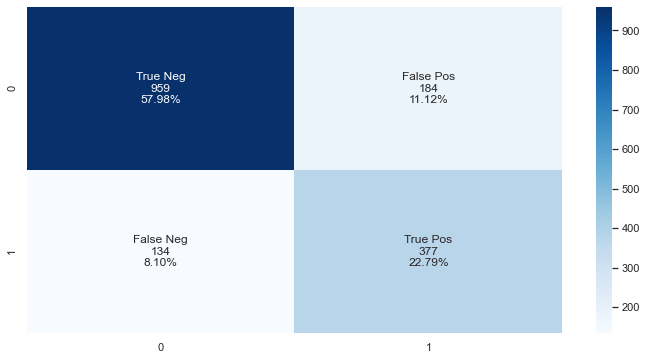

In [136]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                conf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues');

Now let's calculate the metrics and visualize them

In [137]:
%%time
accuracy = accuracy_score(target_test, prediction)
precision = precision_score(target_test, prediction)
recall = recall_score(target_test, prediction)
f1 = f1_score(target_test, prediction)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1:', f1)

Accuracy: 0.8077388149939541
Precision: 0.6720142602495544
Recall: 0.7377690802348337
F1: 0.7033582089552239
CPU times: user 10.7 ms, sys: 2.52 ms, total: 13.2 ms
Wall time: 10.8 ms


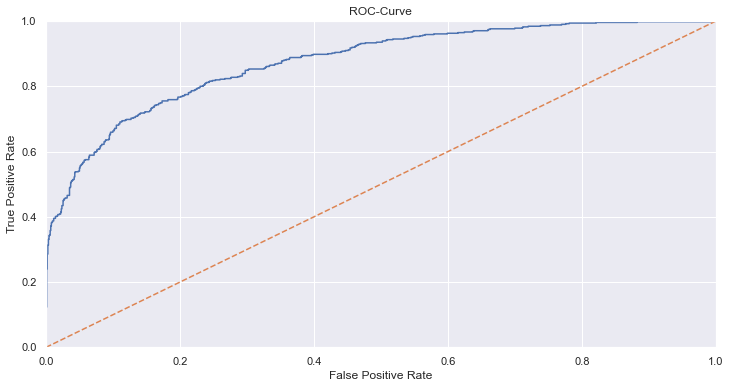

In [138]:
probabilities = final_model.predict_proba(features_test)[:, 1] 

fpr, tpr, thresholds = roc_curve(target_test, probabilities)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], linestyle= '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-Curve')
plt.show()

In [139]:
auc_roc = roc_auc_score(target_test, probabilities)
print('AUC:',auc_roc)

AUC: 0.8744977083344034


Now let's study the influence of features on the prediction result

In [140]:
important_features = pd.Series(data=final_model.feature_importances_,index=features_test.columns)\
                       .to_frame(name='importance')
important_features.reset_index(level=0, inplace=True)

important_features.columns = ['name', 'importance']

important_features = important_features.sort_values(by='importance', ascending=False)
important_features

,name,importance
3,tenure,970
1,MonthlyCharges,610
2,TotalCharges,507
4,gender_Male,85
11,PaymentMethod_Electronic check,82
17,TechSupport_Yes,68
14,OnlineSecurity_Yes,59
9,PaperlessBilling_Yes,55
15,OnlineBackup_Yes,51
21,MultipleLines_Yes,49


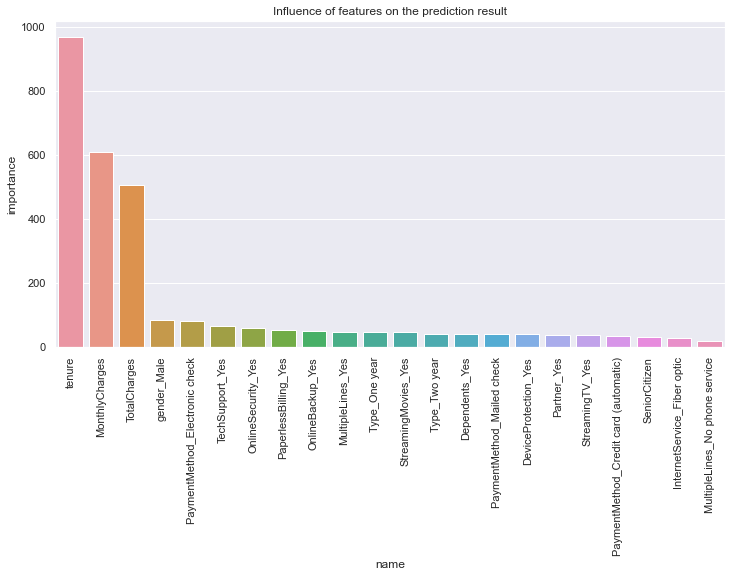

In [148]:
ax = sns.barplot(data = important_features, x='name', y='importance')
plt.title('Influence of features on the prediction result')
plt.xticks(rotation=90);



## Output

* At this step, the final model was tested on a test sample. A random forest was chosen as the final model, the method of dealing with imbalance is to increase the positive class in the sample
* An error matrix was built:
    - True Positive (TP) - 959
    - True Negative (TN) - 377
    - False Positive (FP) - 134
    - False Negative (FN) - 184
* The error matrices were calculated with the following metrics:
    - Accuracy: 0.8077388149939541
    - Precision: 0.6720142602495544
    - Recall: 0.7377690802348337
    - F1: 0.7033582089552239
* An ROC curve was built. AUC value - 0.87450
* In addition, at this step, the influence of signs on the forecast was studied (in descending order of weight):
    tenure - 970
    - MonthlyCharges - 610
    - TotalCharges - 507
    
* The rest of the features have a much lesser effect on the result of the prediction